In [1]:
import sys
print(sys.version)
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_USE_LEGACY_KERAS'] = "1"

3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [2]:
import datetime
import copy
import torch
from torch.utils.data import TensorDataset
import logging
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from bs4 import BeautifulSoup
#import xml.etree.ElementTree as Xet
from argparse import ArgumentParser
from neuralforecast import NeuralForecast
#from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss
from sklearn.preprocessing import MinMaxScaler
#from nbeats_pytorch.model import NBeatsNet
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm



2025-03-03 14:16:47.217620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741007807.357919    9929 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741007807.400595    9929 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 14:16:47.702209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  war

In [3]:
class DataLoader:
    """
    Load data into desired formats for training/validation/testing, including preprocessing.
    """

    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.scaler = list()
        self.historical_values = list()  # first by patient idx, then by col_idx

    def preprocessing(
        self,
        lst_train_arrays,
        lst_test_arrays,
        # train_mode=True, # flag for train_mode (split into train/val), test_mode (no split)
        train_size=0.8,
        normalize=False,
        sequence_stride=6,
        target_col=0,
        exog_cols=[1, 2, 3, 4],
        horizon=12
    ):
        self.normalize = normalize
        self.sequence_stride = sequence_stride
        self.target_col = target_col
        self.exog_cols = exog_cols
        train_arrays = copy.deepcopy(lst_train_arrays)
        test_arrays = copy.deepcopy(lst_test_arrays)
        # count valid timesteps for each individual series
        # train_array.shape = n_timesteps x n_features
        self.valid_steps_train = [train_array.shape[0] for train_array in train_arrays]
        train_lst, val_lst, test_lst = list(), list(), list()
        for idx in range(len(train_arrays)):
            print(idx, "index")
            bg_sample_train = train_arrays[idx]
            #bg_sample_train_exog = np.delete(train_arrays[idx], 0, 1)
            bg_sample_test = test_arrays[idx]#[:, target_col]
            #bg_sample_test_exog = np.delete(test_arrays[idx], 0, 1)
            valid_steps_sample = self.valid_steps_train[idx]
            #train_target = bg_sample_train_target[: int(train_size * valid_steps_sample)].copy()
            train = bg_sample_train[: int(train_size * valid_steps_sample), :].copy()
            #val_target = bg_sample_train_target[int(train_size * valid_steps_sample) :].copy()
            val = bg_sample_train[int(train_size * valid_steps_sample) :, :].copy()
            #test_target = bg_sample_test_target[:].copy()
            test = bg_sample_test[:, :].copy()
            if self.normalize:
                scaler_cols = list()
                # train.shape = n_train_timesteps x n_features
                for col_idx in range(train.shape[1]):
                    scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
                    train[:, col_idx] = remove_extra_dim(
                        scaler.fit_transform((add_extra_dim(train[:, col_idx])))
                    )
                    val[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(val[:, col_idx]))
                    )
                    test[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(test[:, col_idx]))
                    )
                    scaler_cols.append(scaler)  # by col_idx, each feature
                self.scaler.append(scaler_cols)  # by pat_idx, each patient
                
            lst_hist_values = list()
            for col_idx in range(train.shape[1]):
                all_train_col = np.concatenate((train[:, col_idx], val[:, col_idx]))
                # decimals = 1, 2 OR 3?
                unique_values = np.unique(np.round(all_train_col, decimals=2))
                lst_hist_values.append(unique_values)
            self.historical_values.append(lst_hist_values)

            train_lst.append(train)
            #train_lst_exog.append(train_exog)
            val_lst.append(val)
            #val_lst_exog.append(val_exog)
            test_lst.append(test)
            #test_lst_exog.append(test_exog)
        

        (
            self.X_train_exog,
            self.X_train_target,
            self.Y_train,
            self.train_idxs,
        ) = self.create_sequences(
            train_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_val_exog,
            self.X_val_target,
            self.Y_val,
            self.val_idxs,
        ) = self.create_sequences(
            val_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_test_exog,
            self.X_test_target,
            self.Y_test,
            self.test_idxs,
        ) = self.create_sequences(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_exog,
            self.X_reg_target,
            self.reg_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_reg_val_exog,
            self.X_reg_val_target,
            self.reg_val_idxs,
        ) = self.create_sequences_reg(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        
    @staticmethod
    def create_sequences(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        X_exogs, X_targets, Ys, sample_idxs = list(), list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                input_series_exog = series[i : (i + back_horizon)]
                input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                input_series_target = series[i : (i + back_horizon), [target_col]]
                output_series = series[
                    (i + back_horizon) : (i + back_horizon + horizon), [target_col]
                ]
                #input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                #input_series_target = series[i : (i + back_horizon), [target_col]]
                #input_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                
                # TODO: add future plans as additional variables (?)
                if np.isfinite(input_series_exog).all() and np.isfinite(input_series_target).all() and np.isfinite(output_series).all():
                    X_exogs.append(input_series_exog)
                    X_targets.append(input_series_target)
                    Ys.append(output_series)
                    #Xs_target.append(input_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(X_exogs), np.array(X_targets), np.array(Ys), np.array(sample_idxs)

    @staticmethod
    def create_sequences_reg(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        Xs_exog, Xs_target, sample_idxs = list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                output_series_exog = series[(i + back_horizon) : (i + back_horizon + horizon)]
                output_series_exog = np.delete(output_series_exog, [target_col], axis=1)
                output_series_target = series[(i + back_horizon) : (i + back_horizon + horizon), [target_col]]
                # TODO: add future plans as additional variables (?)
                if np.isfinite(output_series_exog).all() and np.isfinite(output_series_target).all():
                    Xs_exog.append(output_series_exog)
                    Xs_target.append(output_series_target)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
                        
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(Xs_exog), np.array(Xs_target), np.array(sample_idxs)      


In [4]:
# remove an extra dimension
def remove_extra_dim(input_array):
    # 2d to 1d
    if len(input_array.shape) == 2:
        return np.reshape(input_array, (-1))
    # 3d to 2d (remove the last empty dim)
    elif len(input_array.shape) == 3:
        return np.squeeze(np.asarray(input_array), axis=-1)
    else:
        print("Not implemented.")
        #print(input_array, "JLNA;iknb")

# add an extra dimension
def add_extra_dim(input_array):
    # 1d to 2d
    if len(input_array.shape) == 1:
        return np.reshape(input_array, (-1, 1))
    # 2d to 3d
    elif len(input_array.shape) == 2:
        return np.asarray(input_array)[:, :, np.newaxis]
    else:
        print("Not implemented.")
        #print(input_array, "ALVNAPNV")

# Method: Fix the random seeds to get consistent models
def reset_seeds(seed_value=39):
    # ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    # necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed_value)
    # necessary for starting core Python generated random numbers in a well-defined state.
    python_random.seed(seed_value)
    # set_seed() will make random number generation
    tf.random.set_seed(seed_value)  

In [5]:
def prepare_data(dataset, data_path):
    df = []
    df = pd.DataFrame(df)
    if dataset == "simulated":
        for i,j in zip(["01","02","03","04","05","06","07","08","09","10"],[1,2,3,4,5,6,7,8,9,10]):
            a = pd.read_csv(f"../results/simulation_4/adult#0{i}.csv")
            a["Time"] = a[["Time"]].apply(
                lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
            )
            #a['Time'] = pd.to_datetime(a['Time'])
            #a.rename(columns={"Time":"ds", "BG":"y"}, inplace=True)
            a = a.dropna()
            #date_index = pd.date_range(a.Time[0], periods=len(a),freq='3min')
            #a.index = date_index
            a['patient_id'] = pd.Series([f"{j}" for x in range(len(a.index))])
            df = pd.concat([df,a], ignore_index=True)
        
        #df.drop(['Time','BG','LBGI','HBGI','Risk'], axis=1, inplace=True)
        print("aldingvapnb[", df)
        idx = int( df.shape[0] * 0.8)#TEST_SIZE)
        cut = int((df.shape[0]-idx)/10)
        Y_train_df = df[df.CGM<df['CGM'].values[-cut]] # 132 train
        Y_test_df = df[df.CGM>=df['CGM'].values[-cut]].reset_index(drop=True) # 12 test  
        Y_train_df.to_csv("data/data_simulation/all_train.csv")
        Y_test_df.to_csv("data/data_simulation/all_test.csv")
        df.drop(['Time','BG','LBGI','HBGI','Risk'], axis=1, inplace=True)
        #return df
        
    elif dataset == "ohiot1dm":
        train = []
        test = []
        train = pd.DataFrame(train)
        test = pd.DataFrame(test)
        for i in [540, 544, 552, 567, 584, 596, 559, 563, 570, 575, 588, 591]:
            file_train = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_train.csv")
            file_test = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_test.csv")
            
            file_train['patient_id'] = pd.Series([f"{i}" for x in range(len(file_train.index))])
            file_test['patient_id'] = pd.Series([f"{i}" for x in range(len(file_test.index))])
            
            train = pd.concat([train, file_train], ignore_index=True)
            test = pd.concat([train, file_test], ignore_index=True)
            
        train.to_csv(data_path + "data_OhioT1DM/all_train.csv")
        test.to_csv(data_path + "data_OhioT1DM/all_test.csv")
        

In [6]:
def load_data(dataset, data_path):
    prepare_data(dataset, data_path)
    if dataset == "ohiot1dm":
        train, orig_train = load_ohio_data(data_path, "all_train.csv")
        test, orig_test = load_ohio_data(data_path, "all_test.csv")
    elif dataset == "simulated":
        train, orig_train = load_sim_data(data_path, "all_train.csv")
        test, orig_test = load_sim_data(data_path, "all_test.csv")
    else:
        print("No dataset chosen")
    return train, test, orig_train, orig_test

def load_ohio_data(data_path, file_name="all_train.csv"):
    # load all the patients, combined
    data = pd.read_csv(data_path + "data_OhioT1DM/" + file_name)

    from functools import reduce
    from operator import or_ as union

    def idx_union(mylist):
        idx = reduce(union, (index for index in mylist))
        return idx

    idx_missing = data.loc[data["missing"] != -1].index
    idx_missing_union = idx_union([idx_missing - 1, idx_missing])

    data = data.drop(idx_missing_union)
    data_bg = data[
        [
            "index_new",
            "patient_id",
            "glucose",
            "basal",
            "bolus",
            "carbs",
            "exercise_intensity",
        ]
    ]
    data_bg["time"] = data_bg[["index_new"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("index_new", axis=1)

    data_bg["bolus"][data_bg["bolus"] == -1] = 0
    data_bg["carbs"][data_bg["carbs"] == -1] = 0
    data_bg["exercise_intensity"][data_bg["exercise_intensity"] == -1] = 0
    data_bg["glucose"][data_bg["glucose"] == -1] = np.NaN

    lst_patient_id = [
        540,
        544,
        552,
        567,
        584,
        596,
        559,
        563,
        570,
        575,
        588,
        591,
    ]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][
                    [
                        "glucose",
                        "basal",
                        "bolus",
                        "carbs",
                        "exercise_intensity",
                    ]
                ]
            )
        )
    return lst_arrays, data_bg


def load_sim_data(data_path, file_name="all_train.csv"):
    data = pd.read_csv(data_path + "data_simulation/" + file_name)
    data_bg = data[["patient_id", "Time", "CGM", "CHO", "insulin"]]
    #print(data_bg)
    data_bg["time"] = data_bg[["Time"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("Time", axis=1)
    lst_patient_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][["CGM", "CHO", "insulin"]]
            )
        )
    return lst_arrays, data_bg
    

In [7]:
def forecast_metrics(dataset, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        for i in range(dataset.X_test_exog.shape[0]): #test? reg?
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
            idx = dataset.test_idxs[i]
            scaler = dataset.scaler[idx]

            Y_test_original.append(
                scaler[dataset.target_col].inverse_transform(dataset.Y_test[i])
            )
            Y_pred_original.append(
                scaler[dataset.target_col].inverse_transform(Y_pred[i].numpy().reshape(-1,1))#Y_pred[i])
            )

        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.Y_test
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    print("Y_pred", Y_pred_original)
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse

def forecast_metrics_single(Y_orig, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        #for i in range(dataset.X_test_exog.shape[0]):
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
        #    idx = dataset.test_idxs[i]
        scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
        
        Y_test_original = scaler.inverse_transform(Y_orig)  # Ensure correct shape
        Y_pred_original = scaler.inverse_transform(Y_pred.numpy().reshape(-1, 1))  # Ensure correct shape


        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.X_test_target
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    #print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse


def polynomial_values(shift, change_percent, poly_order, horizon, desired_steps=None):
    """
    shift: e.g., +0.1 (110% of the start value)
    change_percent: e.g., 0.1 (10% increase)
    poly_order: e.g., order 1, or 2, ...
    horizon: the forecasting horizon
    desired_steps: the desired timesteps for the change_percent to finally happen (can be larger than horizon)
    """
    if horizon == 1:
        return np.asarray([shift + change_percent])
    desired_steps = desired_steps if desired_steps else horizon

    p_orders = [shift]  # intercept
    p_orders.extend([0 for i in range(poly_order)])
    p_orders[-1] = change_percent / ((desired_steps - 1) ** poly_order)

    p = np.polynomial.Polynomial(p_orders)
    p_coefs = list(reversed(p.coef))
    value_lst = np.asarray([np.polyval(p_coefs, i) for i in range(desired_steps)])

    return value_lst[:horizon]


def generate_bounds(
    center,
    shift,
    desired_center,
    poly_order,
    horizon,
    fraction_std,
    input_series,
    desired_steps,
):
    if input_series[-1] == 0:
        center = "mean"
    if center == "last":
        start_value = input_series[-1]
    elif center == "median":
        start_value = np.median(input_series)
    elif center == "mean":
        start_value = np.mean(input_series)
    elif center == "min":
        start_value = np.min(input_series)
    elif center == "max":
        start_value = np.max(input_series)
    else:
        print("Center: not implemented.")

    std = np.std(input_series)
    # Calculate the change_percent based on the desired center (in 2 hours)
    change_percent = (desired_center - start_value) / start_value
    # Create a default fluctuating range for the upper and lower bound if std is too small
    fluct_range = fraction_std * std if fraction_std * std >= 0.025 else 0.025
    upper = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            + fluct_range
        )
    )
    lower = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            - fluct_range
        )
    )
    return upper, lower

In [8]:
parser = ArgumentParser()
parser.add_argument( "--dataset", type=str, help="Choose dataset.")
parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
parser.add_argument( "--forecast-model", type=str, default=None, help="Choose forecaster for initial multivariate forecasting (gru, nbeatsx) ")
# Parse the arguments from a string
args = parser.parse_args("--dataset ohiot1dm --horizon 3 --back-horizon 6 --random-seed 32 --train-size 0.8 --test-group hyper --forecast-model gru".split())
#args = parser.parse_args("--dataset simulated --horizon 6 --back-horizon 6 --random-seed 32 --train-size 0.8 --test-group hyper".split())
#args = parser.parse_args()
data_path = "./data/"
lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path) #misschien toch load_data gebruiken?
print(lst_arrays, orig_train)
print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0].shape}")
print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0].shape}")

print(f"===========Desired trend parameters=============")
center = "last"
desired_shift, poly_order = 0, 1
fraction_std = 1#args.fraction_std
print(f"center: {center}, desired_shift: {desired_shift};")
print(f"fraction_std:{fraction_std};")
print(f"desired_change:'sample_based', poly_order:{poly_order}.")

TARGET_COL = 0
if args.dataset == "ohiot1dm":
    CHANGE_COLS = [1, 2, 3, 4]
elif args.dataset == "simulated": #???
    CHANGE_COLS = [1, 2]
else:
    CHANGE_COLS = None

RANDOM_STATE = args.random_seed
TRAIN_SIZE = args.train_size
horizon, back_horizon = args.horizon, args.back_horizon
dataset = DataLoader(horizon, back_horizon)
dataset.preprocessing(#???
    lst_train_arrays=lst_arrays,
    lst_test_arrays=lst_arrays_test,
    train_size=TRAIN_SIZE,
    normalize=True,
    sequence_stride= horizon,
    target_col=TARGET_COL,
    exog_cols=CHANGE_COLS,
    horizon = horizon
)

#print(dataset.X_train.shape, dataset.Y_train.shape)
#print(dataset.X_val.shape, dataset.Y_val.shape)
#print(dataset.X_test.shape, dataset.Y_test.shape)

# Define N-BEATS Block
class NBeatsBlock(layers.Layer):
    def __init__(self, units, horizon, n_in_features, **kwargs):
        super(NBeatsBlock, self).__init__(**kwargs)
        self.fc1 = layers.Dense(units, activation="relu")
        self.fc2 = layers.Dense(units, activation="relu")
        self.fc3 = layers.Dense(units, activation="relu")
        self.fc4 = layers.Dense(units, activation="relu")
        self.backcast = layers.Dense(horizon * n_in_features, activation="linear")  
        self.forecast = layers.Dense(horizon * n_in_features, activation="linear")  

    def call(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        backcast = self.backcast(x)
        forecast = self.forecast(x)
        return forecast

def build_nbeats_model(back_horizon, n_in_features, horizon, units=256):
    inputs = keras.Input(shape=(back_horizon, n_in_features))
    x = layers.Flatten()(inputs)  # Flatten time series input

    # Stack multiple N-BEATS blocks
    x = NBeatsBlock(units, horizon, n_in_features)(x)
    x = tf.reshape(x, (-1, horizon, n_in_features))  # Reshape to match output shape

    model = keras.Model(inputs, x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mae")
    return model

print("Shape", dataset.X_train_exog.shape, dataset.X_train_target.shape, dataset.Y_train.shape, dataset.X_test_exog.shape, dataset.X_test_target.shape)
X_train = np.concatenate((dataset.X_train_exog, dataset.X_train_target), axis=-1)
y_train = dataset.Y_train
X_test = np.concatenate((dataset.X_test_exog, dataset.X_test_target), axis=-1)
y_test = dataset.X_test_target
X_val = np.concatenate((dataset.X_val_exog, dataset.X_val_target), axis=-1)
y_val = dataset.Y_val

exog_train = dataset.X_train_exog
exog_test = dataset.X_test_exog
exog_val = dataset.X_val_exog

tf.random.set_seed(args.random_seed)

n_in_features = X_train.shape[2]
n_out_features = 1
n_exog_features = exog_train.shape[2]

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True
)
#if args.forecast_model == "gru":
forecast_GRU = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(back_horizon, n_in_features)),
    tf.keras.layers.GRU(100, activation="tanh", return_sequences=True),
    tf.keras.layers.GRU(100, activation="tanh", return_sequences=False),
    tf.keras.layers.Dense(horizon * n_in_features, activation="linear"),
    tf.keras.layers.Reshape((horizon, n_in_features))
])

forecast_GRU.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss="mae")
#tf_model_exog.fit(exog_train, exog_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(exog_val, exog_val[:, -horizon:, :]), callbacks=[early_stopping])
forecast_GRU.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])


pred_all_GRU = forecast_GRU.predict(X_test)

#elif args.forecast_model == "nbeatsx":
forecast_NBEATS = build_nbeats_model(back_horizon, n_in_features, horizon)
forecast_NBEATS.fit(X_train, y_train[:, -horizon:, :], epochs=200, batch_size=64, validation_data=(X_val, y_val[:, -horizon:, :]), callbacks=[early_stopping])
pred_all_NBEATS = forecast_NBEATS.predict(X_test)

'''
tf_model_target = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(horizon, n_in_features)),
        # Shape [batch, time, features] => [batch, time, gru_units]
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=True),
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=False),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(horizon * n_out_features, activation="linear"),
        tf.keras.layers.Reshape((horizon, n_out_features)),
    ]
)
'''
#orig_test_metric = np.asarray(orig_test.drop(['time'], axis=1))#[orig_test.patient_id==544], 'patient_id'
#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
#tf_model_target.compile(optimizer=optimizer, loss="mae")
#tf_model.compile(optimizer='adam', loss='mse')
#tf_model_target.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping],) #, validation_data=(X_test, y_test)
#pred_exog = tf_model_exog.predict(exog_test)
#X_test_future = np.concatenate((pred_exog, dataset.X_test_target[:, -horizon:, :]), axis=-1)  # Combine predicted exog with last known target
#pred_tf = tf_model_target.predict(X_test_future)  # Forecast target


#pred_tf = tf_model(X_test)#[-horizon:])
print(pred_all_GRU, pred_all_NBEATS)



/tmp/ipykernel_9929/1151642609.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["time"] = data_bg[["index_new"]].apply(
/tmp/ipykernel_9929/1151642609.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["bolus"][data_bg["bolus"] == -1] = 0
/tmp/ipykernel_9929/1151642609.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["carbs"][data_bg["carbs"] == 

[array([[   nan,   0.8 ,   0.  ,   0.  ,   0.  ],
       [   nan,   1.05,   0.8 ,   0.  ,   0.  ],
       [   nan,   0.95,   0.  ,   0.  ,   0.  ],
       ...,
       [258.  ,   0.8 ,   0.  ,   0.  ,   0.  ],
       [257.  ,   0.8 ,   0.  ,   0.  ,   0.  ],
       [255.  ,   0.8 ,   0.  ,   0.  ,   0.  ]]), array([[129. ,   1.8,   0. ,   0. ,   0. ],
       [128. ,   1.8,   0. ,   0. ,   0. ],
       [129. ,   1.8,   0. ,   0. ,   0. ],
       ...,
       [169. ,   1.5,   0. ,   0. ,   0. ],
       [164. ,   1.5,   0. ,   0. ,   0. ],
       [  nan,   1.5,   0. ,   0. ,   7. ]]), array([[  nan,   1.3,   0. ,   0. ,   0. ],
       [  nan,   1.3,   1.5,   0. ,   0. ],
       [  nan,   1.3,   8.5,   0. ,   0. ],
       ...,
       [197. ,   1.1,   0. ,   0. ,   0. ],
       [188. ,   1.1,   0. ,   0. ,   0. ],
       [182. ,   1.1,   0. ,   0. ,   0. ]]), array([[ 72.  ,   0.85,   0.  ,   0.  ,   0.  ],
       [ 71.  ,   0.85,   0.  ,   0.  ,   0.  ],
       [ 71.  ,   0.85,   0.  ,   0. 

2025-03-03 14:18:08.402184: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/200
542/544 [============================>.] - ETA: 0s - loss: 0.0739

2025-03-03 14:18:30.906988: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


544/544 [==============================] - 25s 33ms/step - loss: 0.0738 - val_loss: 0.0382
Epoch 2/200
544/544 [==============================] - 15s 27ms/step - loss: 0.0335 - val_loss: 0.0309
Epoch 3/200
544/544 [==============================] - 14s 26ms/step - loss: 0.0253 - val_loss: 0.0242
Epoch 4/200
544/544 [==============================] - 17s 31ms/step - loss: 0.0208 - val_loss: 0.0210
Epoch 5/200
544/544 [==============================] - 17s 31ms/step - loss: 0.0191 - val_loss: 0.0206
Epoch 6/200
544/544 [==============================] - 16s 30ms/step - loss: 0.0182 - val_loss: 0.0187
Epoch 7/200
544/544 [==============================] - 14s 25ms/step - loss: 0.0177 - val_loss: 0.0182
Epoch 8/200
544/544 [==============================] - 14s 25ms/step - loss: 0.0172 - val_loss: 0.0180
Epoch 9/200
544/544 [==============================] - 14s 25ms/step - loss: 0.0169 - val_loss: 0.0176
Epoch 10/200
544/544 [==============================] - 14s 25ms/step - loss: 0.0166 

2025-03-03 14:26:04.049245: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1399/1399 [==============================] - 13s 9ms/step
Epoch 1/200
543/544 [============================>.] - ETA: 0s - loss: 0.0416

2025-03-03 14:26:25.597899: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


544/544 [==============================] - 7s 11ms/step - loss: 0.0416 - val_loss: 0.0238
Epoch 2/200
544/544 [==============================] - 5s 10ms/step - loss: 0.0201 - val_loss: 0.0202
Epoch 3/200
544/544 [==============================] - 5s 10ms/step - loss: 0.0189 - val_loss: 0.0194
Epoch 4/200
544/544 [==============================] - 5s 10ms/step - loss: 0.0183 - val_loss: 0.0188
Epoch 5/200
544/544 [==============================] - 5s 10ms/step - loss: 0.0179 - val_loss: 0.0185
Epoch 6/200
544/544 [==============================] - 5s 10ms/step - loss: 0.0175 - val_loss: 0.0181
Epoch 7/200
544/544 [==============================] - 5s 10ms/step - loss: 0.0171 - val_loss: 0.0193
Epoch 8/200
544/544 [==============================] - 5s 10ms/step - loss: 0.0170 - val_loss: 0.0186
Epoch 9/200
544/544 [==============================] - 5s 10ms/step - loss: 0.0167 - val_loss: 0.0178
Epoch 10/200
544/544 [==============================] - 5s 10ms/step - loss: 0.0168 - val_loss

2025-03-03 14:28:46.057346: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


1399/1399 [==============================] - 6s 4ms/step
[[[0.08572827 0.08525024 0.08581091 0.08606876 0.08493979]
  [0.0880738  0.08725698 0.08708557 0.08623517 0.08759014]
  [0.09080634 0.09087683 0.08980424 0.08923446 0.08949463]]

 [[0.17933507 0.17903663 0.1798083  0.1796683  0.17717418]
  [0.1979266  0.19680846 0.19558902 0.19565013 0.19504155]
  [0.20935492 0.2116098  0.20871519 0.2127204  0.21119553]]

 [[0.2724696  0.2722599  0.27184284 0.2704053  0.2702924 ]
  [0.2928524  0.28963128 0.2910988  0.29112393 0.29149228]
  [0.30336082 0.30331764 0.30474913 0.30424625 0.3029339 ]]

 ...

 [[0.35251984 0.35280418 0.35287267 0.3532185  0.35135502]
  [0.35076717 0.34818476 0.34762383 0.34761712 0.34926564]
  [0.3470849  0.34874764 0.34615698 0.34404907 0.3450263 ]]

 [[0.33542985 0.33576107 0.33583865 0.3361182  0.33437398]
  [0.33287105 0.33040333 0.32978144 0.32983804 0.33157566]
  [0.32894945 0.3305919  0.3279978  0.32593277 0.32681254]]

 [[0.32232878 0.32270855 0.32283643 0.3231

Y_pred [[[ 68.2046 ]
  [ 68.97628]
  [ 69.87529]]

 [[ 99.00124]
  [105.11785]
  [108.87777]]

 [[129.6425 ]
  [136.34843]
  [139.80571]]

 ...

 [[158.44667]
  [157.85776]
  [156.62053]]

 [[152.70442]
  [151.84467]
  [150.52701]]

 [[148.30246]
  [147.91086]
  [146.64058]]]
gru model trained, with test sMAPE score 3.7463; test RMSE score: 9.3048.
Y_pred [[[ 66.60896 ]
  [ 66.85095 ]
  [ 66.10238 ]]

 [[100.17305 ]
  [107.222786]
  [111.96161 ]]

 [[128.85287 ]
  [134.53337 ]
  [144.54492 ]]

 ...

 [[157.01253 ]
  [155.60037 ]
  [153.71713 ]]

 [[151.87569 ]
  [150.2223  ]
  [148.37454 ]]

 [[147.77669 ]
  [146.46303 ]
  [144.76274 ]]]
nbeats model trained, with test sMAPE score 3.7679; test RMSE score: 9.1798.
TEST (44745, 3) (44745, 3) (44745, 3)


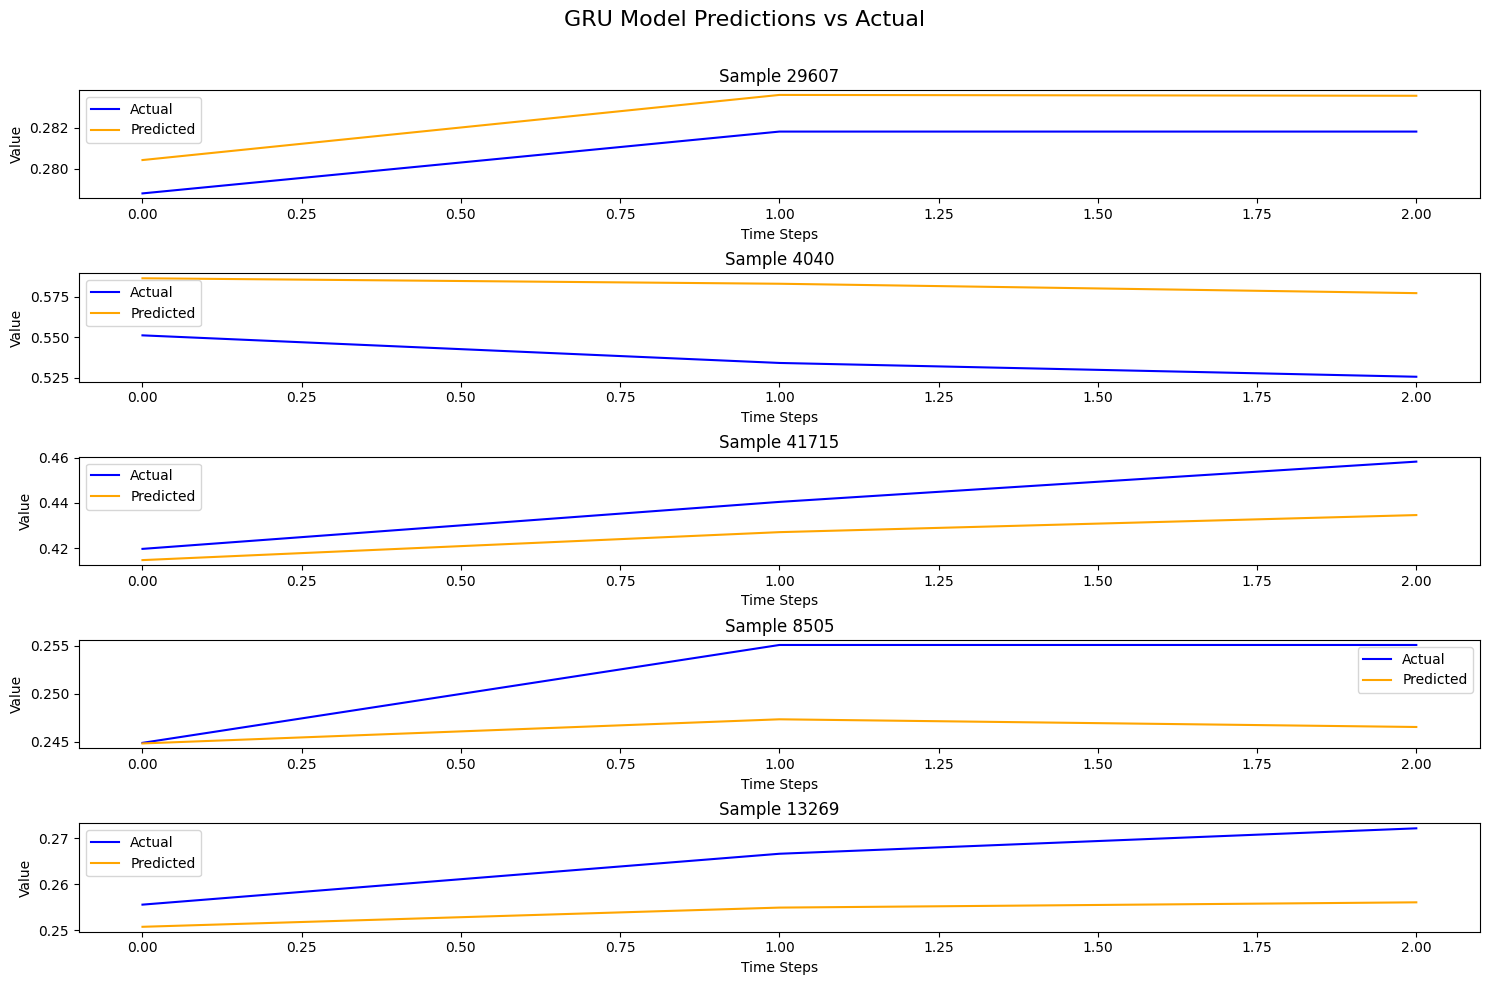

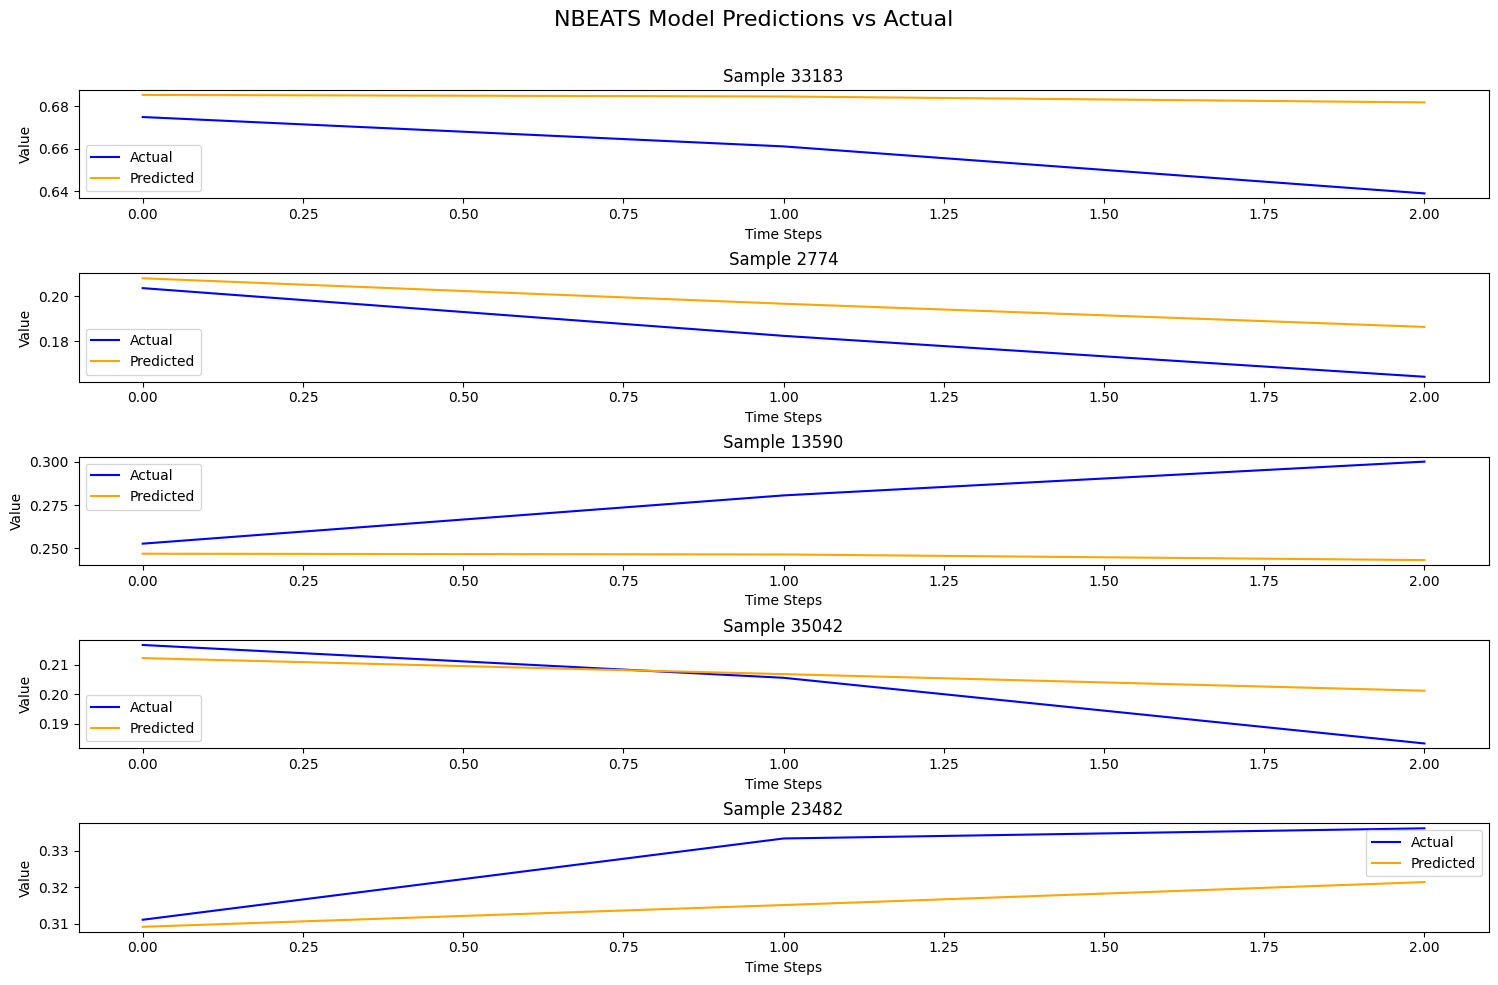

In [9]:

pred_tf_gru = pred_all_GRU[:,:,0]
pred_tf_gru = tf.convert_to_tensor(pred_tf_gru, dtype=tf.float32)
pred_exog_gru = pred_all_GRU[:,:,1:]
pred_tf_nbeats = pred_all_NBEATS[:,:,0]
pred_tf_nbeats = tf.convert_to_tensor(pred_tf_nbeats, dtype=tf.float32)
pred_exog_nbeats = pred_all_NBEATS[:,:,1:]
#print(dataset.X_test_exog.shape[0], dataset.Y_test, pred_tf)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_gru)
print(
    f"gru model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf_nbeats)
print(
    f"nbeats model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
def plot_predictions(y_true, y_pred, name, title='Model Predictions vs Actual', num_samples=5):

    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Select a random sample of indices to plot
    indices = np.random.choice(y_true.shape[0], num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(indices):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(y_true[idx], label='Actual', color='blue')
        plt.plot(y_pred[idx], label='Predicted', color='orange')
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust the top to make room for the title
    plt.savefig(f"plot_predictions{name}.png")
    plt.show()

# Assuming you have your predictions and actual values
# pred_tf is the output from your model
# dataset.Y_test is the actual target values
# Reshape predictions if necessary
pred_tf_reshaped_gru = pred_tf_gru.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
pred_tf_reshaped_nbeats = pred_tf_nbeats.numpy().reshape(-1, horizon)  # Adjust based on your output shape #.numpy()
y_test_reshaped = dataset.Y_test.reshape(-1, horizon)  # Adjust based on your target shape
print("TEST", pred_tf_reshaped_gru.shape, pred_tf_reshaped_nbeats.shape, y_test_reshaped.shape)
# Call the plotting function
plot_predictions(y_test_reshaped, pred_tf_reshaped_gru, "gru", title='GRU Model Predictions vs Actual')
plot_predictions(y_test_reshaped, pred_tf_reshaped_nbeats, "nbeats", title='NBEATS Model Predictions vs Actual')

#for i in range(dataset.X_test_exog.shape[0]):
#print(pred_tf)

Feature 0 - X_pred shape: (44745, 3, 1)
Feature 1 - X_pred shape: (44745, 3, 1)
Feature 2 - X_pred shape: (44745, 3, 1)
Feature 3 - X_pred shape: (44745, 3, 1)
Feature 0 - X_pred shape: (44745, 3, 1)
Feature 1 - X_pred shape: (44745, 3, 1)
Feature 2 - X_pred shape: (44745, 3, 1)
Feature 3 - X_pred shape: (44745, 3, 1)
GRU exogenous model - Feature 0: sMAPE = 61.1735, RMSE = 147.6517.
GRU exogenous model - Feature 1: sMAPE = 105.2047, RMSE = 129.4685.
GRU exogenous model - Feature 2: sMAPE = 106.1295, RMSE = 130.1077.
GRU exogenous model - Feature 3: sMAPE = 106.0088, RMSE = 131.0659.
NBEATS exogenous model - Feature 0: sMAPE = 61.4193, RMSE = 148.0171.
NBEATS exogenous model - Feature 1: sMAPE = 105.1173, RMSE = 129.1850.
NBEATS exogenous model - Feature 2: sMAPE = 106.0030, RMSE = 129.7342.
NBEATS exogenous model - Feature 3: sMAPE = 105.8429, RMSE = 130.4823.
y_true (45515, 3, 4) y_pred (44745, 3, 4)


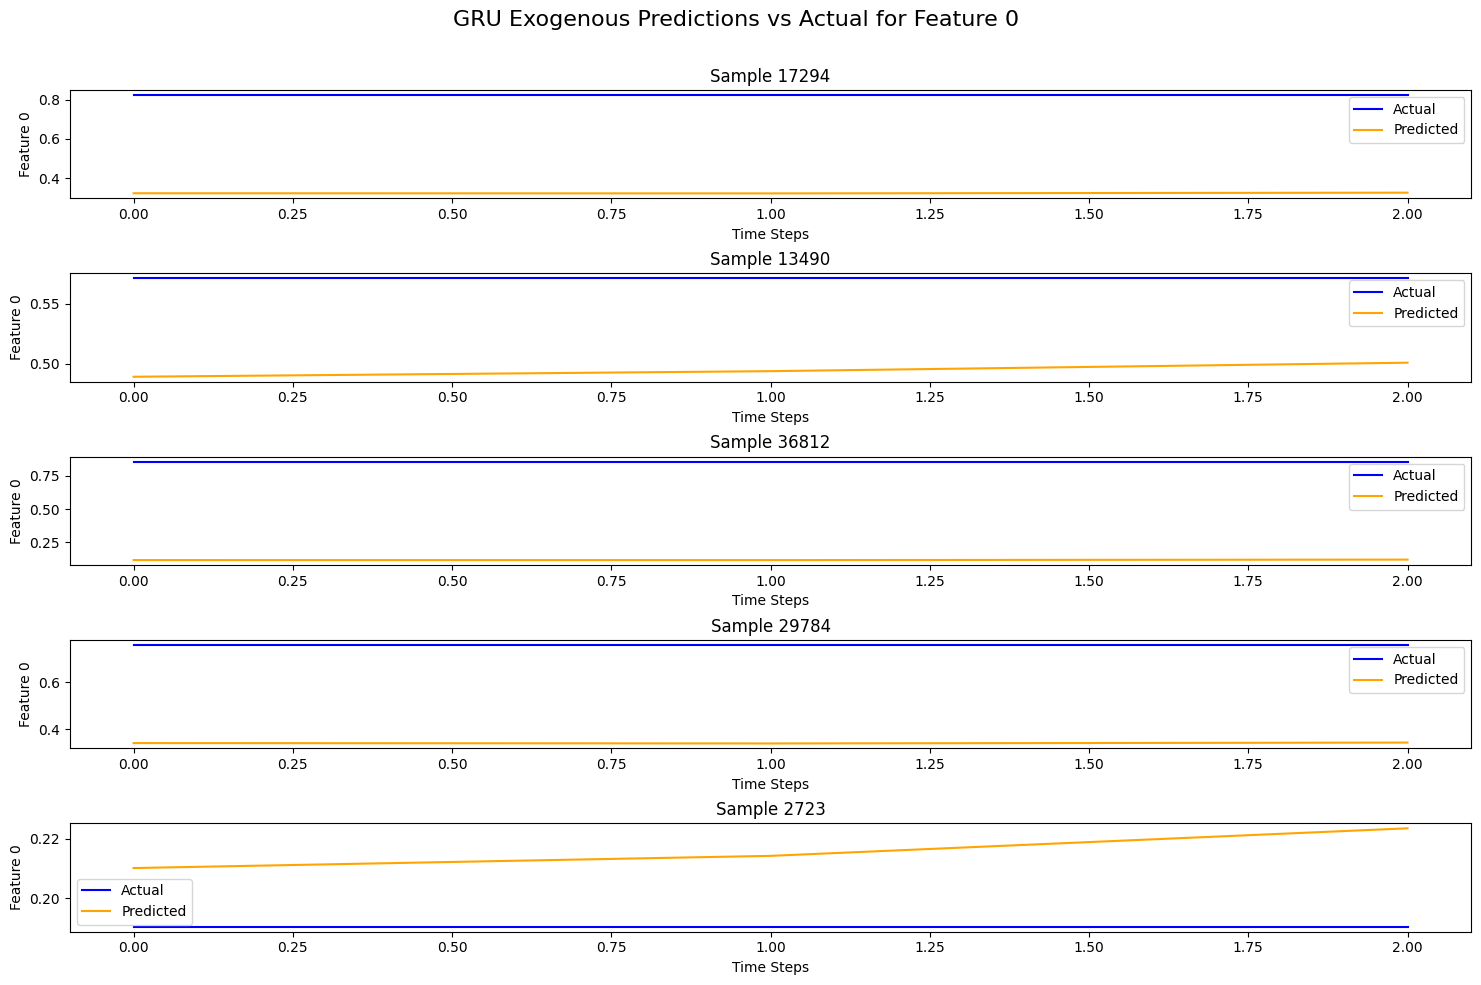

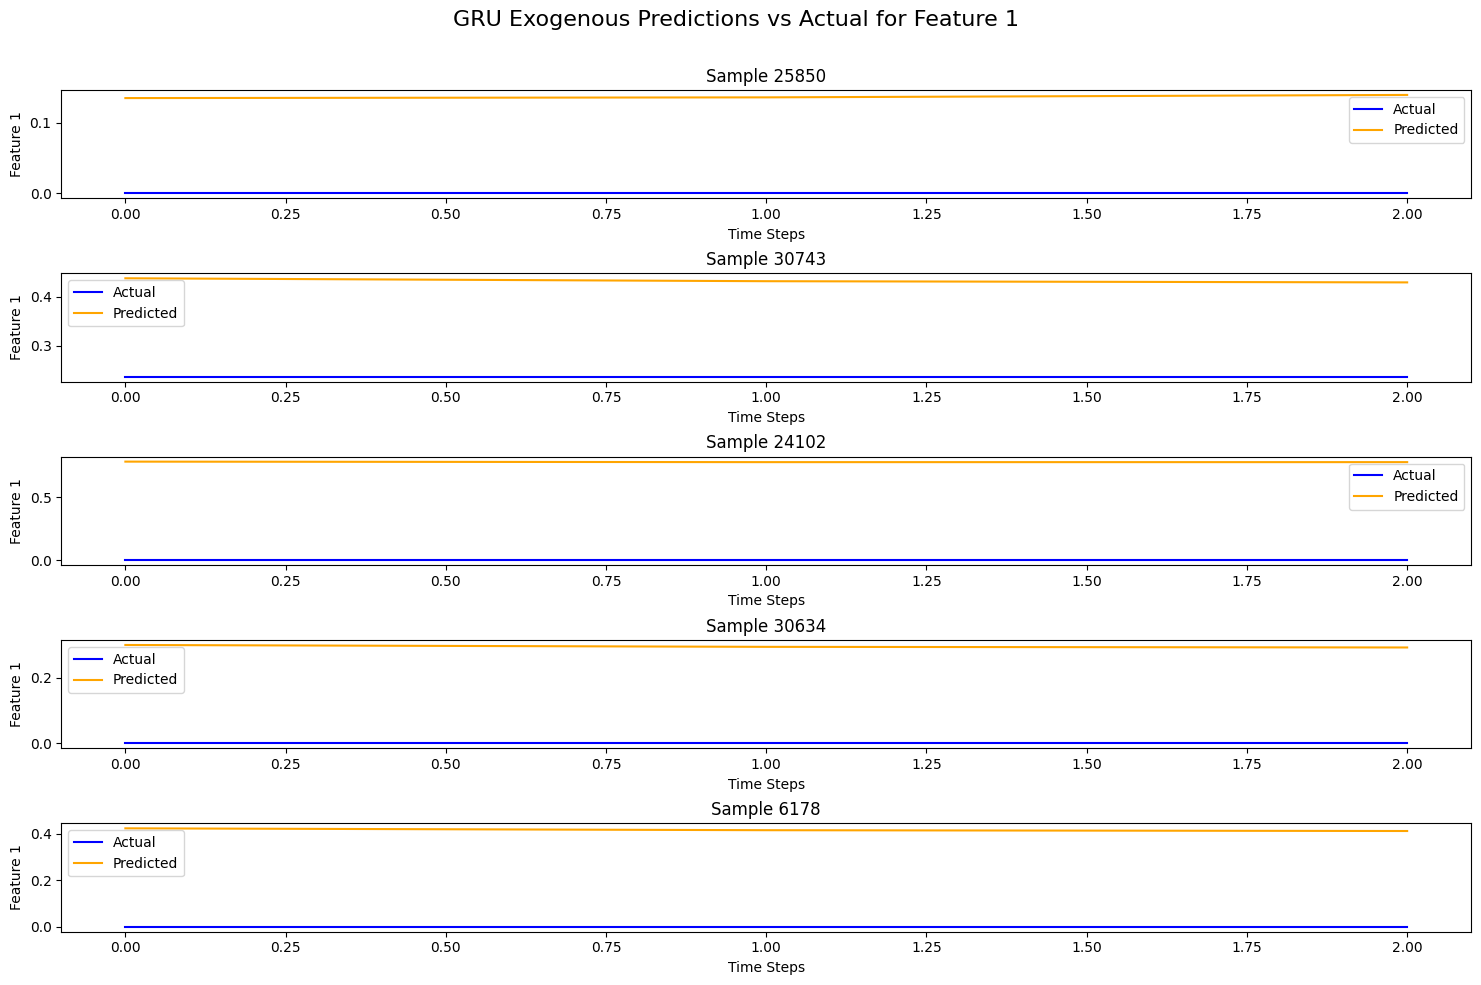

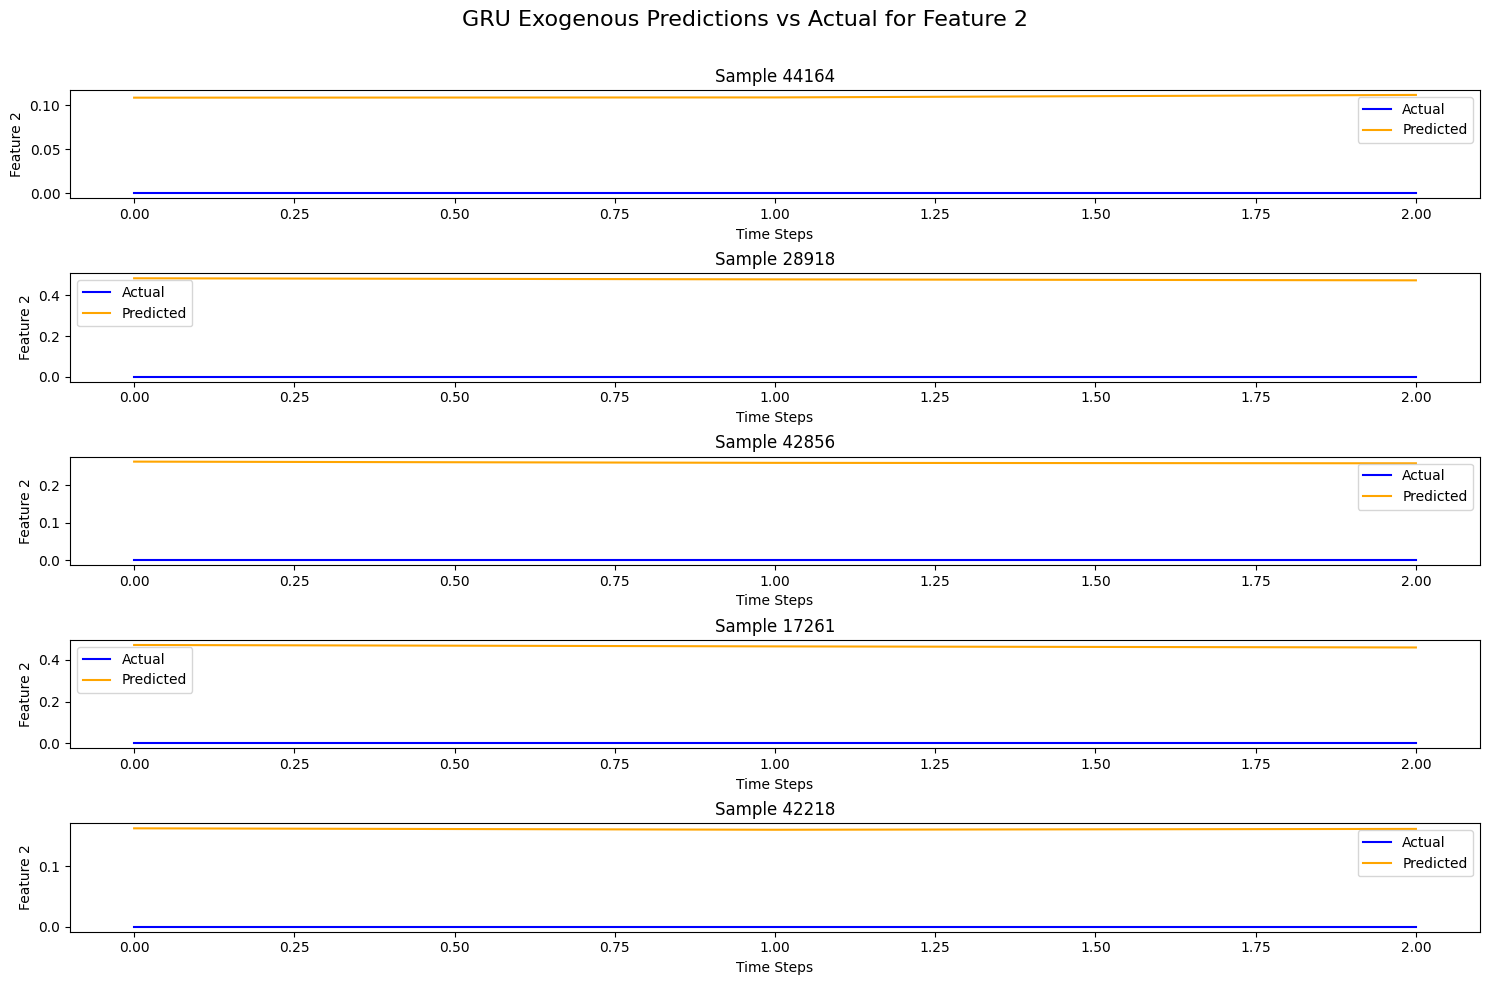

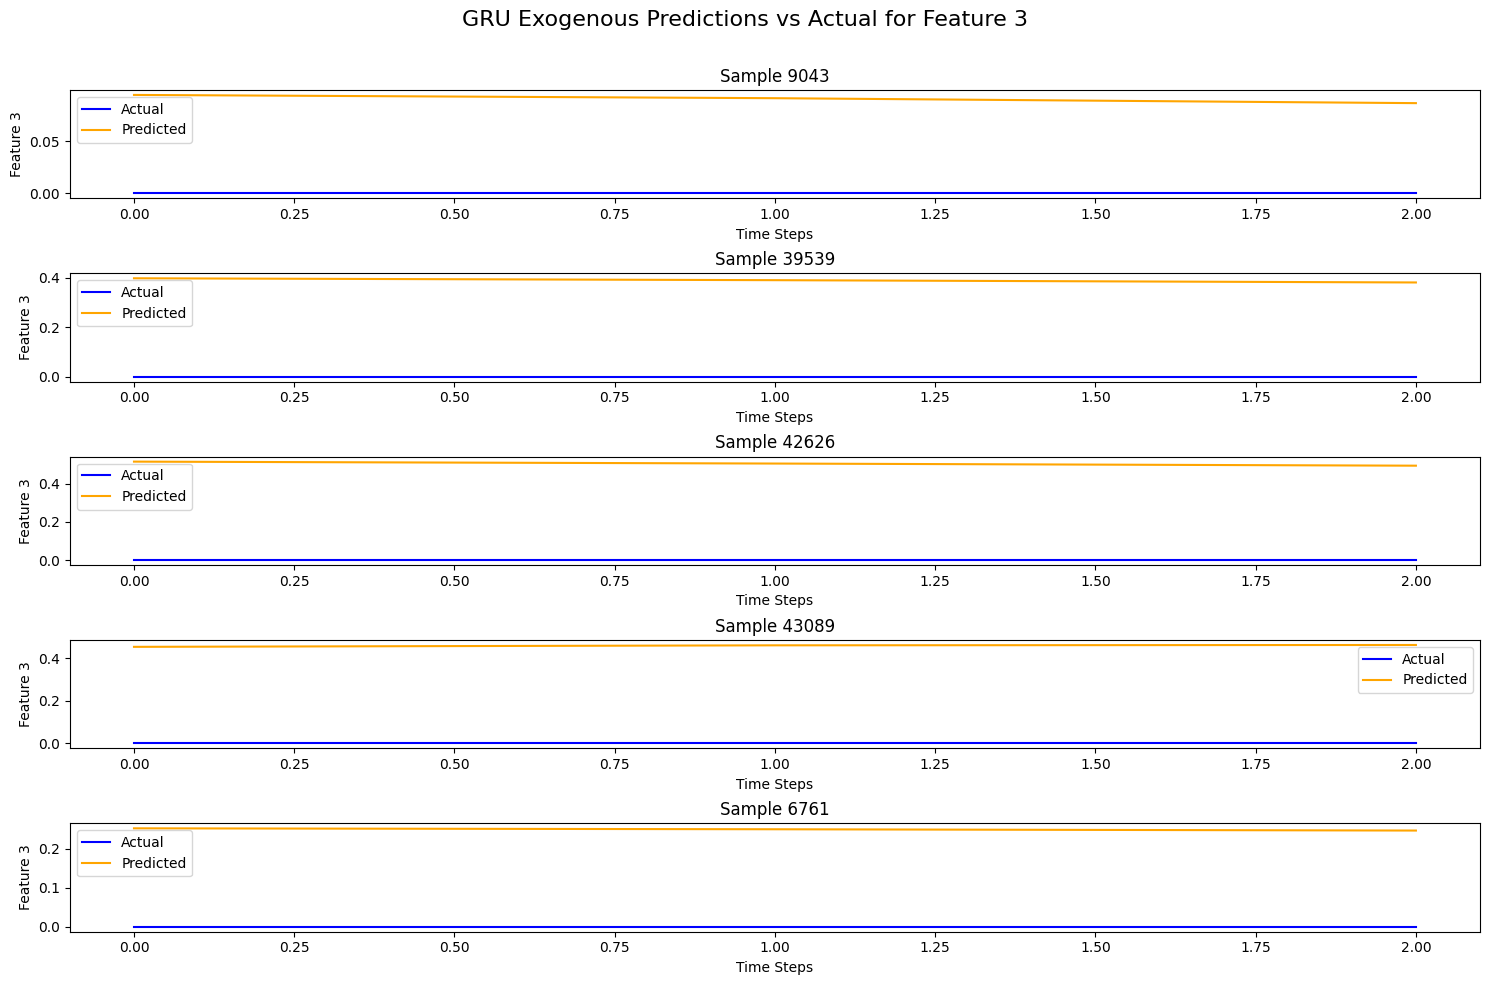

y_true (45515, 3, 4) y_pred (44745, 3, 4)


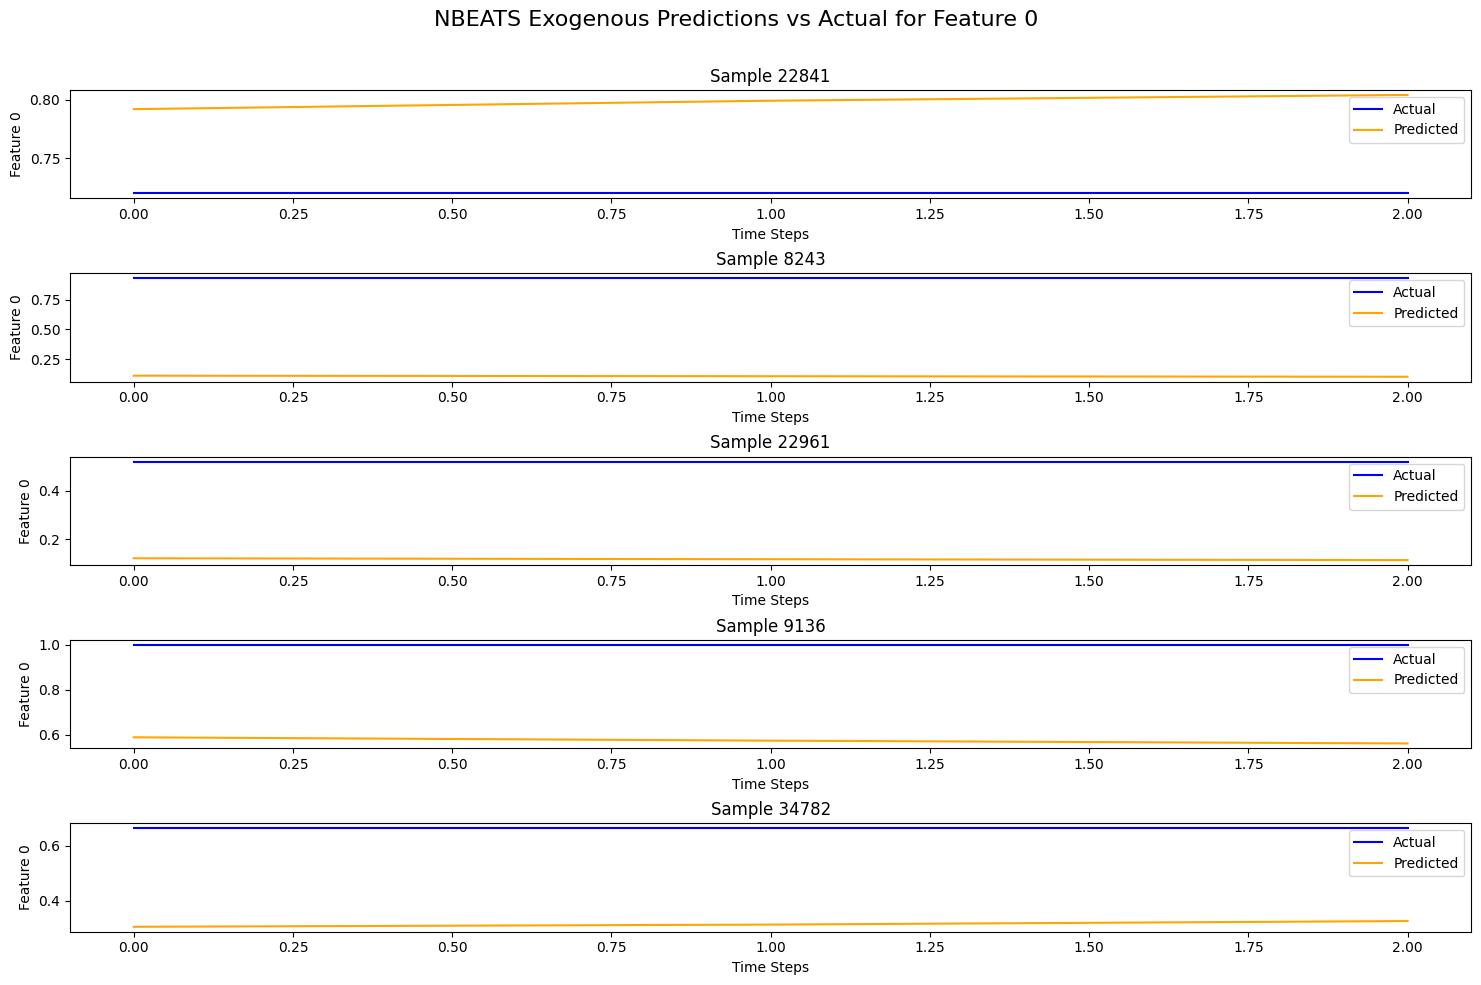

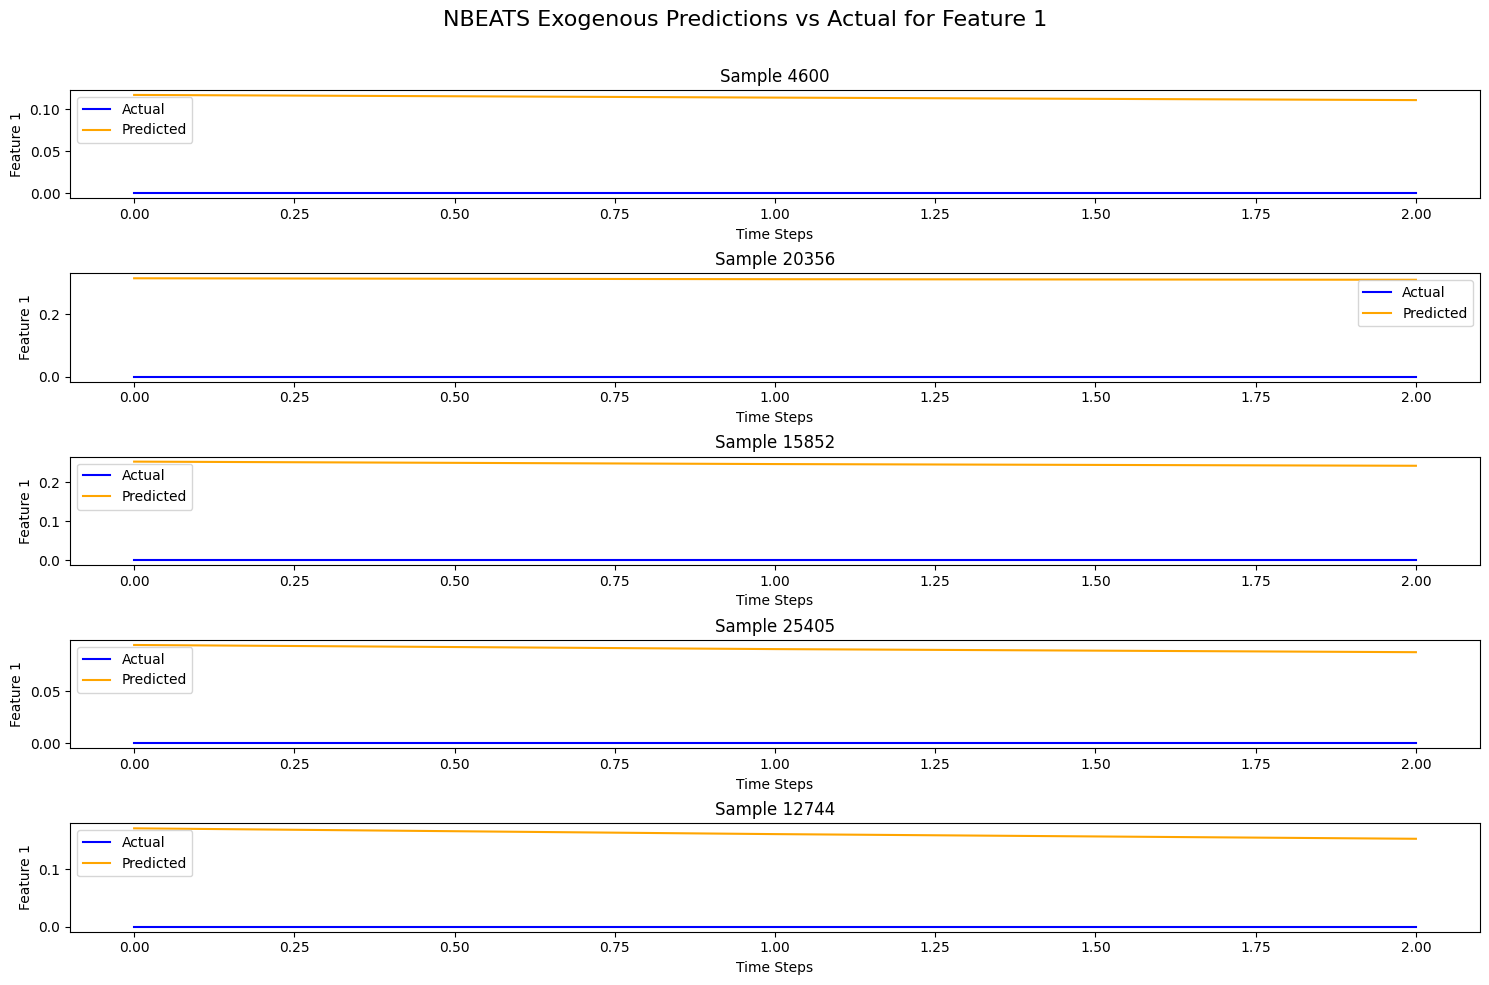

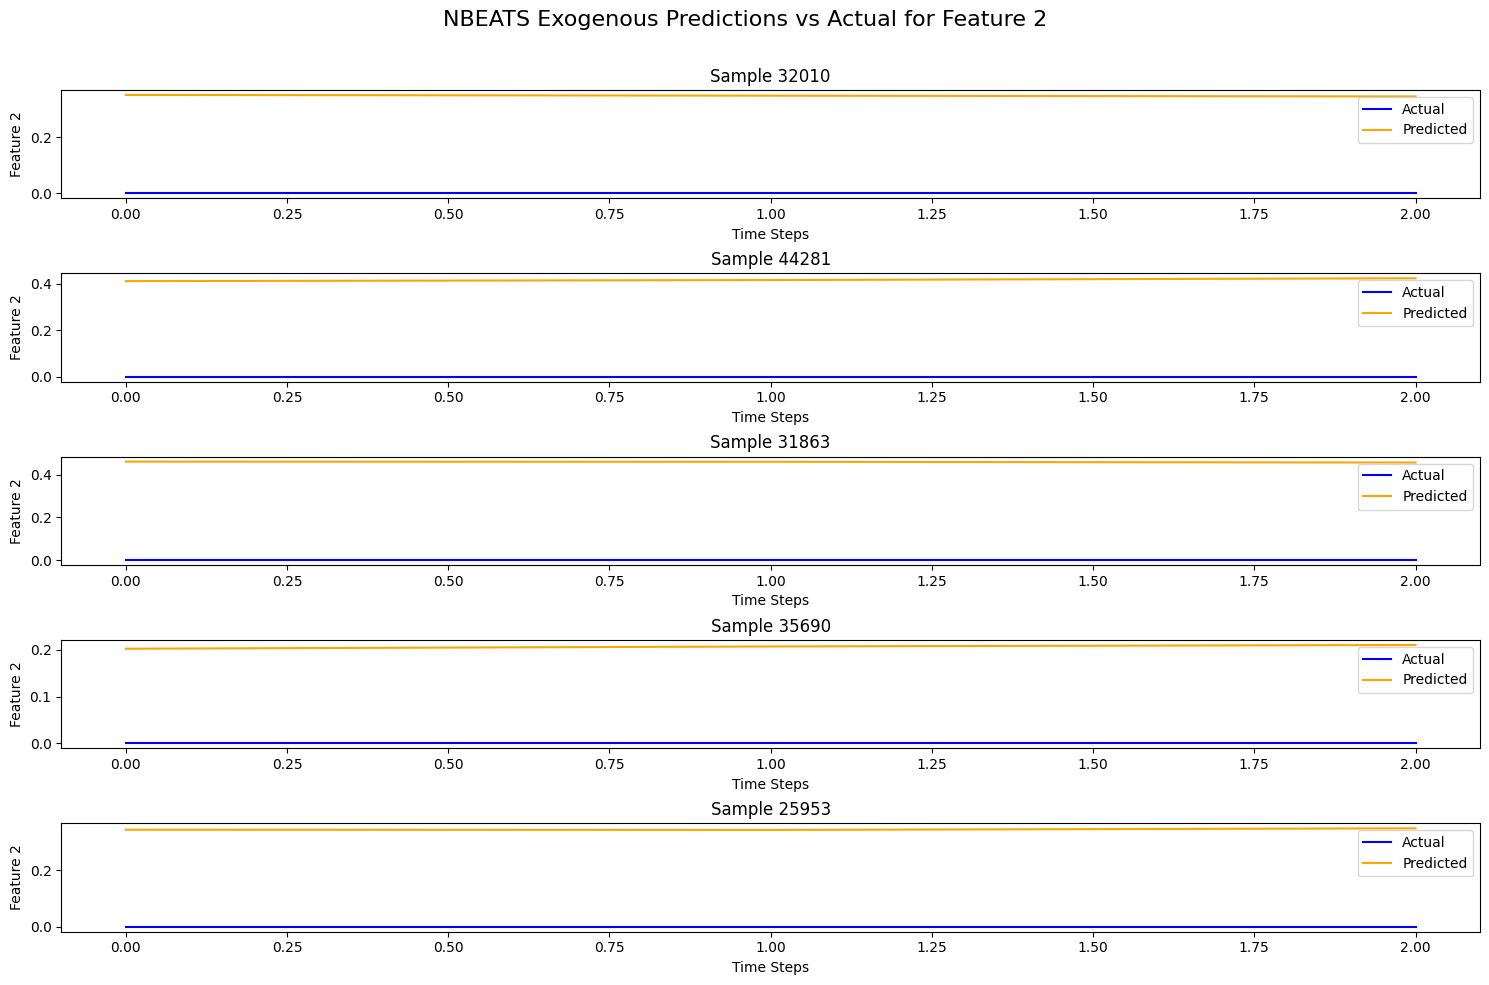

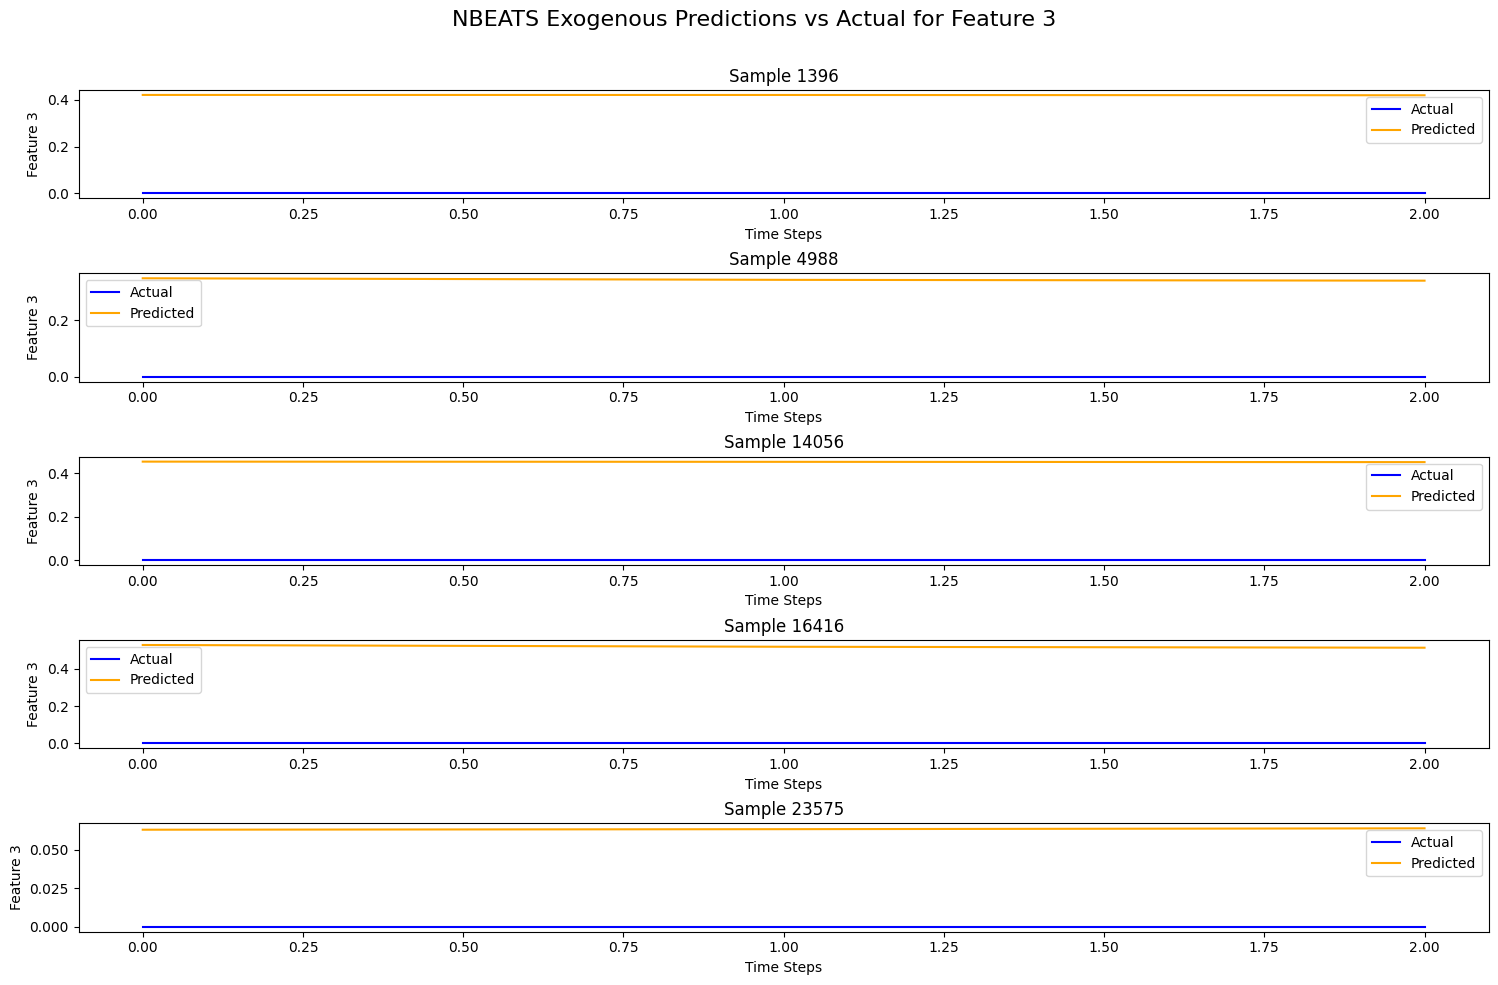

In [22]:
# Function to compute sMAPE and RMSE for each feature
def forecast_metrics_exog_per_feature(dataset, X_pred, inverse_transform=True):
    """
    Compute sMAPE and RMSE metrics for each feature in the exogenous variables.
    
    Args:
        dataset: Dataset object containing test data and scalers.
        X_pred: Predicted exogenous variables from the model.
        inverse_transform: Whether to apply inverse scaling.
    
    Returns:
        feature_metrics: A dictionary containing the mean sMAPE and RMSE for each feature.
    """
    feature_metrics = {}

    # Loop over each feature (4 features in total)
    for feature_idx in range(X_pred.shape[-1]):
        X_test_original, X_pred_original = [], []
        min_length = min(dataset.X_reg_exog.shape[0], X_pred.shape[0])

        if inverse_transform:
            for i in range(min_length):  # Loop over test samples
                idx = dataset.reg_idxs[i]  # Get corresponding index
                scaler = dataset.scaler[idx]  # Retrieve the scaler for the sample

                # FIX: Ensure `scaler` is an instance of StandardScaler or MinMaxScaler
                if isinstance(scaler, list):
                    scaler = scaler[0]  # Take the first scaler if it's a list

                if not hasattr(scaler, "inverse_transform"):  
                    raise TypeError(f"Expected a scaler object, but got {type(scaler)} for index {idx}")

                # Inverse transform actual and predicted exogenous features for the current feature
                X_test_original.append(
                    scaler.inverse_transform(dataset.X_reg_exog[i][:, feature_idx].reshape(-1, 1))
                )
                X_pred_original.append(
                    scaler.inverse_transform(X_pred[i][:, feature_idx].numpy().reshape(-1, 1))
                )

            X_test_original = np.array(X_test_original)
            X_pred_original = np.array(X_pred_original)
        else:
            X_test_original = dataset.X_reg_exog[:, :, feature_idx]
            X_pred_original = X_pred[:, :, feature_idx]

        def smape(X_test, X_pred):
            """ Symmetric Mean Absolute Percentage Error """
            def smape_sample(actual, forecast):
                return 200 * np.mean(
                    np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast) + 1e-8)  # Avoid division by zero
                )

            return np.mean([smape_sample(X_test[i], X_pred[i]) for i in range(len(X_pred))])

        def rmse(X_test, X_pred):
            """ Root Mean Squared Error """
            return np.sqrt(np.mean((X_pred - X_test) ** 2))

        print(f"Feature {feature_idx} - X_pred shape:", X_pred_original.shape)
        
        mean_smape = smape(X_test_original, X_pred_original)
        mean_rmse = rmse(X_test_original, X_pred_original)
        
        feature_metrics[feature_idx] = {
            "sMAPE": mean_smape,
            "RMSE": mean_rmse
        }

    return feature_metrics

# Function to plot predictions vs actual values for each feature
def plot_predictions_exog_per_feature(y_true, y_pred, name, title='Exogenous Model Predictions vs Actual for Feature', num_samples=5):
    """
    Plot predictions vs actual values for each feature.
    """
    print("y_true", y_true.shape, "y_pred", y_pred.shape)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Ensure num_samples does not exceed the number of available samples
    num_samples = min(num_samples, y_true.shape[0])

    for feature_idx in range(y_true.shape[-1]):
        # Randomly sample some indices for plotting
        indices = np.random.choice(y_true.shape[0], num_samples, replace=False)

        # Create the plot
        plt.figure(figsize=(15, 10))

        for i, idx in enumerate(indices):
            plt.subplot(num_samples, 1, i + 1)

            # Plot actual and predicted values for the current feature
            plt.plot(y_true[idx, :, feature_idx], label='Actual', color='blue')
            plt.plot(y_pred[idx, :, feature_idx], label='Predicted', color='orange')

            # Set title, labels, and legend
            plt.title(f'Sample {idx + 1}')
            plt.xlabel('Time Steps')
            plt.ylabel(f'Feature {feature_idx}')
            plt.legend()

        # Adjust layout for better visualization
        plt.tight_layout()
        plt.suptitle(f'{title} for Feature {feature_idx}', fontsize=16)
        plt.subplots_adjust(top=0.9)  # Adjust spacing for the title
        plt.savefig(f"plot_predictions_exog_{name}_feature_{feature_idx}.png")
        plt.show()

# Reshape predictions for plotting
pred_exog_reshaped_gru = pred_exog_gru.numpy()
pred_exog_reshaped_nbeats = pred_exog_nbeats.numpy()
x_test_reshaped = dataset.X_reg_exog  # True exogenous values

# Compute forecast metrics for each feature
feature_metrics_gru = forecast_metrics_exog_per_feature(dataset, pred_exog_gru)
feature_metrics_nbeats = forecast_metrics_exog_per_feature(dataset, pred_exog_nbeats)

# Print the metrics for each feature
for feature_idx in feature_metrics_gru:
    print(f"GRU exogenous model - Feature {feature_idx}: sMAPE = {feature_metrics_gru[feature_idx]['sMAPE']:0.4f}, RMSE = {feature_metrics_gru[feature_idx]['RMSE']:0.4f}.")
    
for feature_idx in feature_metrics_nbeats:
    print(f"NBEATS exogenous model - Feature {feature_idx}: sMAPE = {feature_metrics_nbeats[feature_idx]['sMAPE']:0.4f}, RMSE = {feature_metrics_nbeats[feature_idx]['RMSE']:0.4f}.")

# Plot results for each feature
plot_predictions_exog_per_feature(x_test_reshaped, pred_exog_reshaped_gru, "gru_exog", title="GRU Exogenous Predictions vs Actual")
plot_predictions_exog_per_feature(x_test_reshaped, pred_exog_reshaped_nbeats, "nbeats_exog", title="NBEATS Exogenous Predictions vs Actual")


In [38]:
hyper_bound, hypo_bound = 180, 70
print(f"===========CF generation setup=============")
print(f"hyper bound value: {hyper_bound}, hypo bound: {hypo_bound}.")

args = parser.parse_args("--dataset ohiot1dm --horizon 3 --back-horizon 6 --random-seed 32 --train-size 0.8 --test-group hyper".split())
event_labels = list()
for i in range(len(pred_tf)):
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original = scaler.inverse_transform(tf.reshape(pred_tf[i], (1, -1)).numpy())
    if np.any(Y_preds_original >= hyper_bound):
        event_labels.append("hyper")
    elif np.any(Y_preds_original <= hypo_bound):
        event_labels.append("hypo")
    else:
        event_labels.append("normal")
hyper_indices = np.argwhere(np.array(event_labels) == "hyper").reshape(-1)
hypo_indices = np.argwhere(np.array(event_labels) == "hypo").reshape(-1)

print(f"hyper_indices shape: {hyper_indices.shape}")
print(f"hypo_indices shape: {hypo_indices.shape}")

print("LSASLSLKDGNS", Y_preds_original)
#plot(orig_train, orig_test, Y_preds_original)

# use a subset of the test
rand_test_size = 100
print(args.test_group)
if args.test_group == "hyper":
    if len(hyper_indices) >= rand_test_size:
        print("if", hyper_indices)
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hyper_indices, rand_test_size, replace=False
        )
    else:
        print("else", hyper_indices)
        rand_test_idx = hyper_indices
elif args.test_group == "hypo":
    if len(hypo_indices) >= rand_test_size:
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hypo_indices, rand_test_size, replace=False
        )
    else:
        rand_test_idx = hypo_indices
else:
    rand_test_idx = np.arange(dataset.X_reg_exog.shape[0])

Exog_test = dataset.X_reg_exog[rand_test_idx]
Target_test = dataset.X_reg_target[rand_test_idx]

print("ET", Exog_test, Target_test)

print(
    f"Generating CFs for {len(rand_test_idx)} samples in total, for {args.test_group} test group..."
)

# loss calculation ==> min/max bounds
desired_max_lst, desired_min_lst = list(), list()
hist_inputs = list()

# define the desired center to reach in two hours (24 timesteps for OhioT1DM)
# then we need to cut the first 6 steps to generate the desired bounds
desired_steps = 24 if args.dataset == "ohiot1dm" else 20
if args.test_group == "hyper":
    desired_center_2h = hyper_bound - 10  # -10 for a fluctuating bound
elif args.test_group == "hypo":
    desired_center_2h = hypo_bound + 10  # +10 for a fluctuating bound
else:
    print(
        f"Group not identified: {args.test_group}, use a default center"
    )
    desired_center_2h = (hyper_bound + hypo_bound) / 2
#print(f"desired center {desired_center_2h} in {desired_steps} timesteps.")

for i in range(len(Exog_test)): #???Maybe join exog, target
    idx = dataset.reg_idxs[rand_test_idx[i]]
    scaler = dataset.scaler[idx]

    desired_center_scaled = scaler[TARGET_COL].transform(
        np.array(desired_center_2h).reshape(-1, 1)
    )[0][0]
    #print(
    #    f"desired_center: {desired_center_2h}; after scaling: {desired_center_scaled:0.4f}"
    #)
    # desired trend bounds: use the `center` parameter from the input sequence as the starting point
    desired_max_scaled, desired_min_scaled = generate_bounds(
        center=center,  # Use the parameters defined at the beginning of the script
        shift=desired_shift,
        desired_center=desired_center_scaled,
        poly_order=poly_order,
        horizon=horizon,
        fraction_std=fraction_std,
        input_series=np.transpose(Target_test[i,0]),
        desired_steps=desired_steps,
    )
    print("max", desired_max_scaled)
    # TODO: remove the ones that already satisfy the bounds here, OR afterwards?
    desired_max_lst.append(desired_max_scaled)
    desired_min_lst.append(desired_min_scaled)
    hist_inputs.append(dataset.historical_values[idx])
    
#for i in range(X_test.shape[0]):
#    max_bound = (
#        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
#    )
#    min_bound = (
#        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
#    )


===========CF generation setup=============
hyper bound value: 180, hypo bound: 70.
hyper_indices shape: (15007,)
hypo_indices shape: (1840,)
LSASLSLKDGNS [[147.89603 146.7382  145.62967]]
hyper
if [  116   117   118 ... 44737 44738 44739]
ET [[[0.57142857 0.         0.         0.        ]
  [0.57142857 0.         0.         0.        ]
  [0.57142857 0.         0.         0.        ]]

 [[0.66363636 0.         0.         0.        ]
  [0.66363636 0.         0.         0.        ]
  [0.66363636 0.         0.         0.        ]]

 [[0.77419355 0.         0.         0.        ]
  [0.77419355 0.         0.         0.        ]
  [0.77419355 0.34817814 0.         0.        ]]

 ...

 [[0.825      0.         0.         0.        ]
  [0.825      0.         0.         0.        ]
  [0.825      0.         0.         0.        ]]

 [[1.         0.         0.         0.        ]
  [1.         0.         0.         0.        ]
  [1.         0.         0.         0.        ]]

 [[0.76       0.     

In [100]:
#Statistical new, TEST!!! CHECK!!!

def euclidean_distance(arr1, arr2):
    sum_sq = np.sum(np.square(arr1 - arr2))
    return np.sqrt(sum_sq)
    
def compute_loss(max_bound, min_bound, pred):
    mse_loss_ = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
    dist_max = mse_loss_(max_bound, pred)
    dist_min = mse_loss_(min_bound, pred)
    loss = dist_max + dist_min
    return loss

def compute_gradient_finite_difference(model, X_e, max_bound, min_bound, epsilon=1e-4):
    # Convert to numpy for SARIMAX
    temp = X_e.numpy()
    
    # Get the original prediction
    pred = model.forecast(horizon, start_params=start_params, exog=temp)
    pred = tf.convert_to_tensor(pred, dtype=tf.float32)
    
    # Original loss
    original_loss = compute_loss(max_bound, min_bound, pred)

    # Approximate the gradient using finite differences
    gradients = np.zeros_like(X_e.numpy())
    for i in range(X_e.shape[0]):
        X_e_perturbed = X_e.numpy()
        X_e_perturbed[i] += epsilon
        pred_perturbed = model.forecast(horizon, start_params=start_params, exog=X_e_perturbed)
        pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)
        
        # Compute the perturbed loss
        perturbed_loss = compute_loss(max_bound, min_bound, pred_perturbed)
        
        # Finite difference (gradient approximation)
        gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon
    
    return gradients
    
#all samples
print("shape", pred_tf.shape, pred_exog.shape, len(desired_max_lst))
targets_sarimax = np.empty((len(desired_max_lst), horizon))
orig_targets_sarimax = np.empty((len(desired_max_lst), horizon))
exogs = 4
exogs_sarimax = np.empty((len(desired_max_lst), horizon, exogs))
losses_sarimax = np.empty((len(desired_max_lst), horizon))
max_bound_sarimax = np.empty((len(desired_max_lst), horizon))
min_bound_sarimax = np.empty((len(desired_max_lst), horizon))
#euclidean_min_sarimax = np.empty(Y_test.shape[0])
#euclidean_max_sarimax = np.empty(Y_test.shape[0])

for i in range(len(desired_max_lst)):
    print(f"{i} samples been transformed.")
    max_bound = (
        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
    )
    min_bound = (
        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
    )
    print(min_bound, max_bound)
    min_bound_sarimax[i] = min_bound.squeeze()
    max_bound_sarimax[i] = max_bound.squeeze()
    #rand = random.choice(0, dataset.X_train_exog.shape[0])
    print("test", rand_test_idx, dataset.X_reg_exog.shape)
    X = dataset.X_reg_exog[i]#input_series_target = series[i : (i + back_horizon), [target_col]]
    y = dataset.X_reg_target[i][:,TARGET_COL]
    X_test_exog = pred_exog[rand_test_idx][i]
    print(X.shape,y.shape,X_test_exog)
#X = random.choice(dataset.X_train_exog)
#y = random.choice(dataset.X_train_target)
#X_test_exog = random.choice(dataset.X_test_exog)
    
    
    mod = sm.tsa.SARIMAX(endog=np.asarray(y), exog=np.asarray(X), order=(1,0,0))
    #res = mod.fit(disp=False)
    mod = mod.fit(disp=False)
    start_params = mod.params
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
    
    
    # Initialize the input tensor
    grad_X_e = tf.convert_to_tensor(X_test_exog, dtype=tf.float32)
    grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32)
    
    # Initialize prediction and loss
    print("PRED", pred_tf)
    temp = grad_X_e.numpy()
    pred_sarimax = mod.forecast(horizon, start_params=start_params, exog=temp)
    pred_sarimax = tf.convert_to_tensor(pred_sarimax, dtype=tf.float32)
    if i == 0:
        mean_smape, mean_rmse = forecast_metrics_single(pred_tf[i].numpy().reshape(-1, 1), pred_sarimax)
        print(
            f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
        )
    # Perform optimization
    max_iter = 100
    it = 0
    while (tf.reduce_any(pred_sarimax > max_bound) or tf.reduce_any(pred_sarimax < min_bound)) and (it < max_iter):
        #print("Iteration:", it)
        
        # Compute approximate gradients using finite differences
        gradients = compute_gradient_finite_difference(mod, grad_X_e, max_bound, min_bound)
        
        # Apply gradients using optimizer
        optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])
    
        # Update predictions and loss
        temp = grad_X_e.numpy()
        pred_sarimax = mod.forecast(horizon, start_params=start_params, exog=temp)
        pred_sarimax = tf.convert_to_tensor(pred_sarimax, dtype=tf.float32)
        loss = compute_loss(max_bound, min_bound, pred_sarimax)
        
        #print(f"Iteration {it}, Loss: {loss.numpy()}, Grad_X_e: {grad_X_e.numpy()}")
        it += 1
    
    #print("Optimized value of X:", grad_X_e.numpy(), "Best prediction:", pred_sarimax.numpy())
    
    # Final inversion step if needed
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original_sarimax = scaler.inverse_transform(pred_sarimax.numpy().reshape(-1, 1))  # Ensure correct shape
    print("Original Prediction after scaling inversion:", Y_preds_original_sarimax)
    #dist_min = euclidean_distance(min_bound, pred_sarimax)
    #dist_max = euclidean_distance(pred_sarimax, max_bound)
    targets_sarimax[i] = pred_sarimax.numpy()
    orig_targets_sarimax[i] = Y_preds_original_sarimax.squeeze()
    exogs_sarimax[i] = grad_X_e.numpy().squeeze()
    losses_sarimax[i] = loss
    #euclidean_min_sarimax[i] = dist_min
    #euclidean_max_sarimax[i] = dist_max


print("results", targets_sarimax, exogs_sarimax, losses_sarimax)
#print("distance", euclidean_min_sarimax, euclidean_max_sarimax)
print("bound", min_bound_sarimax, max_bound_sarimax)

shape (44745, 3) (44745, 3, 4) 100
0 samples been transformed.
[[0.0325    ]
 [0.04675121]
 [0.06100242]] [[0.03416667]
 [0.04841787]
 [0.06266908]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.7000096  0.70073694 0.7036413  0.6994921 ]
 [0.6914421  0.6881825  0.6899983  0.68818086]
 [0.6789474  0.6782627  0.67907494 0.6802015 ]]
PRED tf.Tensor(
[[0.08278687 0.08306965 0.08506402]
 [0.17422353 0.1

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[55.80355 ]
 [55.808876]
 [55.800278]]
1 samples been transformed.
[[0.28166667]
 [0.28480676]
 [0.28794686]] [[0.29611111]
 [0.29925121]
 [0.3023913 ]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.39650154 0.39704296 0.39784503 0.396574  ]
 [0.40182978 0.4003479  0.40026352 0.4006721 ]
 [0.4030104  0.40257326 0.40341306 0.40296572]]
PRED tf.Tensor(
[[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[135.03822]
 [137.00565]
 [135.30374]]
2 samples been transformed.
[[0.48333333]
 [0.47676824]
 [0.47020315]] [[0.50811966]
 [0.50155456]
 [0.49498947]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5038823  0.50519776 0.5060397  0.504467  ]
 [0.5063923  0.50455505 0.50423324 0.50514066]
 [0.50487614 0.50370616 0.50520056 0.5042129 ]]
PRED tf.Tensor(
[[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[199.27069]
 [202.33855]
 [199.32391]]
3 samples been transformed.
[[0.49045455]
 [0.4847892 ]
 [0.47912385]] [[0.51560606]
 [0.50994071]
 [0.50427536]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4288541  0.42841637 0.42996666 0.42716032]
 [0.42188138 0.42035267 0.42144236 0.42037815]
 [0.4129382  0.41313934 0.4128117  0.4140077 ]]
PRED tf.Tensor(
[[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[203.47508]
 [201.41098]
 [202.0554 ]]
4 samples been transformed.
[[0.27857143]
 [0.28332893]
 [0.28808643]] [[0.29285714]
 [0.29761464]
 [0.30237214]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4230682  0.42245978 0.42450282 0.42256454]
 [0.42851904 0.42788815 0.42762092 0.427058  ]
 [0.429594   0.42947868 0.43008217 0.42789918]]
PRED tf.Tensor(
[[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[135.98422]
 [134.83769]
 [135.73022]]
5 samples been transformed.
[[0.36340909]
 [0.36340909]
 [0.36340909]] [[0.38204545]
 [0.38204545]
 [0.38204545]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.44588247 0.44692856 0.44791317 0.44967887]
 [0.43996552 0.4415986  0.44040802 0.43993196]
 [0.43006304 0.42706704 0.4306063  0.43052927]]
PRED tf.Tensor(
[[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[164.76303]
 [163.82768]
 [160.86592]]
6 samples been transformed.
[[0.4244898 ]
 [0.42404614]
 [0.42360248]] [[0.4462585 ]
 [0.44581485]
 [0.44537119]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.7989824  0.7986864  0.7995704  0.7974759 ]
 [0.79360104 0.7892499  0.7925378  0.7906727 ]
 [0.785432   0.7860537  0.78663176 0.7869966 ]]
PRED tf.Tensor(
[[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[167.9272 ]
 [173.8716 ]
 [167.60747]]
7 samples been transformed.
[[0.46041667]
 [0.45558575]
 [0.45075483]] [[0.48402778]
 [0.47919686]
 [0.47436594]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.62756807 0.6270491  0.6294998  0.62538195]
 [0.62037575 0.6175277  0.6199036  0.6182339 ]
 [0.61073184 0.61045015 0.6105538  0.61206067]]
PRED tf.Tensor(
[[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[194.99828]
 [193.62708]
 [191.7335 ]]
8 samples been transformed.
[[0.19082569]
 [0.19960112]
 [0.20837655]] [[0.20061162]
 [0.20938705]
 [0.21816248]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.7179211  0.719889   0.7215183  0.7213518 ]
 [0.7011751  0.7033298  0.70495325 0.7013577 ]
 [0.68432075 0.67930055 0.68283194 0.68634653]]
PRED tf.Tensor(
[[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[106.94991]
 [107.07688]
 [107.29026]]
9 samples been transformed.
[[0.02215909]
 [0.03624012]
 [0.05032115]] [[0.02329545]
 [0.03737648]
 [0.05145751]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5964826  0.59705126 0.5996364  0.59547323]
 [0.5915977  0.58967817 0.59049207 0.58934647]
 [0.58450127 0.58288485 0.5833484  0.58304197]]
PRED tf.Tensor(
[[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[52.5184  ]
 [51.619778]
 [52.260136]]
10 samples been transformed.
[[0.32315864]
 [0.32389765]
 [0.32463665]] [[0.33973088]
 [0.34046989]
 [0.34120889]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.7910946  0.7915143  0.7944138  0.7904981 ]
 [0.79365367 0.79025036 0.7913934  0.7924861 ]
 [0.7945399  0.79315263 0.7946747  0.79289806]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[149.91895]
 [147.05496]
 [148.84642]]
11 samples been transformed.
[[0.93166667]
 [0.90582126]
 [0.87997585]] [[0.97944444]
 [0.95359903]
 [0.92775362]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4093296  0.40733203 0.4093847  0.40704888]
 [0.40933245 0.40758178 0.40915394 0.40872547]
 [0.40685928 0.40783542 0.4086213  0.40947738]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[346.74756]
 [346.75452]
 [346.75272]]
12 samples been transformed.
[[0.4875    ]
 [0.48258282]
 [0.47766563]] [[0.5125    ]
 [0.50758282]
 [0.50266563]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.45799828 0.4585242  0.45943326 0.45755666]
 [0.46302813 0.46108654 0.46130604 0.46176657]
 [0.4633325  0.4630069  0.46435776 0.46404797]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[201.8678 ]
 [202.98477]
 [201.56998]]
13 samples been transformed.
[[0.24375   ]
 [0.24858092]
 [0.25341184]] [[0.25625   ]
 [0.26108092]
 [0.26591184]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.48796374 0.48811564 0.48954892 0.48720142]
 [0.4823997  0.4798275  0.48044145 0.48034263]
 [0.4731487  0.47352934 0.47410333 0.47415945]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[123.45698 ]
 [123.7883  ]
 [124.208755]]
14 samples been transformed.
[[0.32592068]
 [0.32653652]
 [0.32715236]] [[0.34263456]
 [0.3432504 ]
 [0.34386624]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.46065715 0.45840913 0.4593361  0.45790073]
 [0.44801718 0.44525626 0.45127442 0.4467406 ]
 [0.4349065  0.4294148  0.4352395  0.43227875]]
PRED tf.Tensor

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[148.4417 ]
 [151.7925 ]
 [152.01132]]
15 samples been transformed.
[[0.27777778]
 [0.28037904]
 [0.2829803 ]] [[0.29202279]
 [0.29462406]
 [0.29722532]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.41026995 0.410369   0.41123056 0.40970093]
 [0.41124156 0.4098047  0.41033313 0.41036147]
 [0.40886167 0.40856272 0.40932506 0.40959355]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[134.34137]
 [134.49352]
 [134.01447]]
16 samples been transformed.
[[0.30136364]
 [0.30413043]
 [0.30689723]] [[0.31681818]
 [0.31958498]
 [0.32235178]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.7534173  0.75358325 0.75511986 0.7529897 ]
 [0.7488568  0.74491924 0.7477247  0.7478244 ]
 [0.7419316  0.7409413  0.7435995  0.7438514 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[142.16785]
 [143.14575]
 [143.9939 ]]
17 samples been transformed.
[[0.31763456]
 [0.3186199 ]
 [0.31960525]] [[0.33392351]
 [0.33490886]
 [0.3358942 ]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5820636  0.58287895 0.5855951  0.5819085 ]
 [0.57598644 0.5722998  0.5727057  0.5726502 ]
 [0.566688   0.56627774 0.56607556 0.56495845]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[59.5521  ]
 [59.11423 ]
 [58.686165]]
18 samples been transformed.
[[0.11876771]
 [0.12862114]
 [0.13847457]] [[0.12485836]
 [0.13471179]
 [0.14456522]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.6610197  0.6600637  0.6633537  0.659514  ]
 [0.6511516  0.6470396  0.6491969  0.64774704]
 [0.6380421  0.6389534  0.63887185 0.6393961 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[47.688858]
 [47.389816]
 [47.102406]]
19 samples been transformed.
[[0.40083333]
 [0.39865942]
 [0.39648551]] [[0.42138889]
 [0.41921498]
 [0.41704106]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.52660024 0.5260385  0.527821   0.5242418 ]
 [0.5344302  0.5336176  0.5343958  0.53314126]
 [0.5379102  0.5379653  0.5377387  0.538842  ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[58.714855]
 [57.512287]
 [56.386993]]
20 samples been transformed.
[[0.065     ]
 [0.07780193]
 [0.09060386]] [[0.06833333]
 [0.08113527]
 [0.0939372 ]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.39137167 0.39138892 0.39251998 0.39046755]
 [0.39756685 0.39588276 0.39657435 0.39632657]
 [0.39942232 0.39920306 0.39978334 0.40018898]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[73.95997]
 [73.91998]
 [73.88004]]
21 samples been transformed.
[[0.4293578 ]
 [0.42749634]
 [0.42563489]] [[0.45137615]
 [0.44951469]
 [0.44765324]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.45284447 0.45683804 0.45635593 0.4542557 ]
 [0.46009517 0.45908058 0.45980695 0.45877483]
 [0.4651452  0.46088105 0.45978326 0.45953932]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[183.42332]
 [185.5202 ]
 [186.89458]]
22 samples been transformed.
[[0.316875  ]
 [0.31844505]
 [0.3200151 ]] [[0.333125  ]
 [0.33469505]
 [0.3362651 ]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.8536989  0.8526334  0.86162263 0.8554699 ]
 [0.86405104 0.86775523 0.863932   0.866041  ]
 [0.86755216 0.8709061  0.8810049  0.88225645]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[145.72879]
 [147.12297]
 [147.59   ]]
23 samples been transformed.
[[0.1103211 ]
 [0.12268648]
 [0.13505185]] [[0.11597859]
 [0.12834397]
 [0.14070935]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.53056455 0.5280012  0.53152996 0.5267509 ]
 [0.5361935  0.53462994 0.5366627  0.5351629 ]
 [0.53750527 0.5388018  0.5399144  0.54134524]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[82.27851]
 [82.2965 ]
 [82.33437]]
24 samples been transformed.
[[0.43431818]
 [0.43115613]
 [0.42799407]] [[0.45659091]
 [0.45342885]
 [0.4502668 ]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5725249  0.57327485 0.5746274  0.5718792 ]
 [0.57532406 0.5735192  0.57379454 0.57394236]
 [0.57426167 0.5734531  0.5744716  0.5742864 ]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[186.25629]
 [187.23361]
 [186.8716 ]]
25 samples been transformed.
[[0.14444444]
 [0.15299145]
 [0.16153846]] [[0.15185185]
 [0.16039886]
 [0.16894587]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.6527136  0.6511236  0.6540061  0.6503147 ]
 [0.6611345  0.6601044  0.6609408  0.6611556 ]
 [0.66689646 0.6663853  0.6678531  0.66823053]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[92.1659 ]
 [92.10815]
 [92.04564]]
26 samples been transformed.
[[0.25113636]
 [0.25614295]
 [0.26114954]] [[0.26401515]
 [0.26902174]
 [0.27402833]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4181921  0.41948858 0.42079666 0.41896412]
 [0.4166662  0.4140997  0.4137567  0.4148378 ]
 [0.4123472  0.41115743 0.4117641  0.41052052]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[126.786194]
 [126.83041 ]
 [126.21576 ]]
27 samples been transformed.
[[0.19058074]
 [0.1972318 ]
 [0.20388287]] [[0.20035411]
 [0.20700517]
 [0.21365624]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.3907618  0.39114338 0.39436412 0.39220178]
 [0.43309173 0.43169266 0.43113023 0.427259  ]
 [0.45825708 0.46195942 0.45963818 0.4523612 ]]
PRED tf.Tensor

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[106.641365]
 [106.5176  ]
 [106.71301 ]]
28 samples been transformed.
[[0.50545326]
 [0.49806319]
 [0.49067311]] [[0.53137394]
 [0.52398387]
 [0.51659379]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.68158376 0.68261886 0.68208975 0.6873254 ]
 [0.6757682  0.6833603  0.6760908  0.6755007 ]
 [0.65687597 0.660803   0.66825664 0.6706249 ]]
PRED tf.Tensor

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[209.79143]
 [207.60773]
 [207.18051]]
29 samples been transformed.
[[0.30875   ]
 [0.31068237]
 [0.31261473]] [[0.32458333]
 [0.3265157 ]
 [0.32844807]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.6587983  0.65944326 0.66239834 0.6591021 ]
 [0.64719397 0.64211726 0.6436296  0.64292866]
 [0.6318542  0.63197386 0.6321761  0.6313435 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[146.10838]
 [144.91554]
 [143.41563]]
30 samples been transformed.
[[0.20041667]
 [0.20717995]
 [0.21394324]] [[0.21069444]
 [0.21745773]
 [0.22422101]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5399678  0.5421906  0.5428125  0.54214615]
 [0.5398882  0.534729   0.53532267 0.5381219 ]
 [0.53856945 0.5360167  0.53759015 0.5335333 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[110.05254]
 [110.15589]
 [110.0276 ]]
31 samples been transformed.
[[0.28172805]
 [0.28431457]
 [0.2869011 ]] [[0.29617564]
 [0.29876216]
 [0.30134869]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.52699316 0.527772   0.52780235 0.52750045]
 [0.5277545  0.5244079  0.5258145  0.5277875 ]
 [0.5234331  0.5226079  0.52643454 0.5262739 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[134.69298]
 [134.7584 ]
 [135.48006]]
32 samples been transformed.
[[0.67653061]
 [0.66484768]
 [0.65316474]] [[0.71122449]
 [0.69954156]
 [0.68785862]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5998112  0.5978694  0.60105914 0.59882903]
 [0.6222121  0.6231649  0.62124616 0.62026983]
 [0.6353645  0.63601947 0.6367741  0.63212985]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[262.84308]
 [262.7359 ]
 [265.4629 ]]
33 samples been transformed.
[[0.29515306]
 [0.30047693]
 [0.3058008 ]] [[0.31028912]
 [0.31561298]
 [0.32093685]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.63521296 0.6318249  0.6352188  0.6300874 ]
 [0.62593555 0.62387604 0.62757486 0.6238665 ]
 [0.61449844 0.61647403 0.61547405 0.61937904]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[142.03853]
 [141.52644]
 [140.8894 ]]
34 samples been transformed.
[[0.609375  ]
 [0.59902303]
 [0.58867107]] [[0.640625  ]
 [0.63027303]
 [0.61992107]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.71077156 0.7114517  0.712278   0.7100159 ]
 [0.7154158  0.71342456 0.7143487  0.7154068 ]
 [0.7168063  0.7156546  0.7183937  0.7181256 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[73.84995]
 [73.70057]
 [73.55184]]
35 samples been transformed.
[[0.23821023]
 [0.24265687]
 [0.24710351]] [[0.25042614]
 [0.25487278]
 [0.25931942]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.42177215 0.4224272  0.4234119  0.42169204]
 [0.42223    0.42025718 0.42040864 0.42088512]
 [0.4192673  0.4187166  0.4194926  0.4192363 ]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[68.93984]
 [68.87982]
 [68.81991]]
36 samples been transformed.
[[0.79422492]
 [0.77598784]
 [0.75775076]] [[0.83495441]
 [0.81671733]
 [0.79848024]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4277152  0.4210906  0.41995463 0.4215127 ]
 [0.4314139  0.4242314  0.43433174 0.4185089 ]
 [0.42753282 0.42528453 0.44249454 0.42929065]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[73.824936]
 [73.650764]
 [73.47749 ]]
37 samples been transformed.
[[0.51458333]
 [0.50733696]
 [0.50009058]] [[0.54097222]
 [0.53372585]
 [0.52647947]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.7359557  0.73575115 0.7349023  0.7359755 ]
 [0.73514986 0.73609793 0.73031443 0.7334632 ]
 [0.73314345 0.73979694 0.74116164 0.73844373]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[94.416016]
 [93.83824 ]
 [93.2666  ]]
38 samples been transformed.
[[0.52      ]
 [0.51301713]
 [0.50603426]] [[0.54666667]
 [0.53968379]
 [0.53270092]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4124483  0.4121546  0.41364646 0.41110316]
 [0.41736642 0.41575652 0.4166722  0.41606778]
 [0.4191886  0.4188772  0.4186422  0.4190663 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[213.21944]
 [211.60565]
 [215.08203]]
39 samples been transformed.
[[0.3618272 ]
 [0.36084185]
 [0.35985651]] [[0.38038244]
 [0.37939709]
 [0.37841175]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.46346226 0.46469343 0.46602336 0.4641695 ]
 [0.45917848 0.45621538 0.4558804  0.45695165]
 [0.4515388  0.45092884 0.45171595 0.4503731 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[159.10858]
 [160.52972]
 [163.09833]]
40 samples been transformed.
[[0.11261398]
 [0.12477204]
 [0.13693009]] [[0.11838906]
 [0.13054711]
 [0.14270517]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.39124465 0.3913717  0.3923699  0.3925064 ]
 [0.41436985 0.41316724 0.4134347  0.41303918]
 [0.4294779  0.43039548 0.42956212 0.42697838]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[82.65113]
 [82.13149]
 [81.61142]]
41 samples been transformed.
[[0.61159091]
 [0.60052372]
 [0.58945652]] [[0.64295455]
 [0.63188735]
 [0.62082016]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4068858  0.40679097 0.40824285 0.40595508]
 [0.41055945 0.40918458 0.40963256 0.40918085]
 [0.41070914 0.41046768 0.41050673 0.41069967]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[241.24083]
 [243.17677]
 [243.74313]]
42 samples been transformed.
[[0.58440367]
 [0.57562824]
 [0.56685281]] [[0.61437309]
 [0.60559766]
 [0.59682223]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.61079955 0.6209818  0.6178966  0.62445676]
 [0.6027934  0.5944624  0.5904875  0.60090464]
 [0.58767027 0.58123595 0.59156036 0.58199775]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[236.22337]
 [235.31921]
 [233.26323]]
43 samples been transformed.
[[0.12222222]
 [0.13176019]
 [0.14129815]] [[0.12849003]
 [0.13802799]
 [0.14756596]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.45795417 0.45705426 0.45888424 0.4569571 ]
 [0.45136222 0.44894794 0.45027035 0.4505247 ]
 [0.44450182 0.44409913 0.44497985 0.44442135]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[83.99539]
 [84.45866]
 [84.59065]]
44 samples been transformed.
[[0.49291667]
 [0.48663647]
 [0.48035628]] [[0.51819444]
 [0.51191425]
 [0.50563406]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.8646985  0.8611432  0.8644562  0.8595504 ]
 [0.861055   0.85812247 0.8643501  0.86196446]
 [0.8596509  0.85839665 0.85955864 0.862849  ]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[202.21277]
 [204.49734]
 [203.01678]]
45 samples been transformed.
[[0.7109375 ]
 [0.69605655]
 [0.6811756 ]] [[0.74739583]
 [0.73251488]
 [0.71763393]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.6566645  0.6564135  0.65906626 0.6548011 ]
 [0.6579311  0.65540594 0.6562546  0.6558896 ]
 [0.6560713  0.65589887 0.655989   0.65570587]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[275.46432]
 [274.49802]
 [275.2623 ]]
46 samples been transformed.
[[0.16791667]
 [0.17612923]
 [0.18434179]] [[0.17652778]
 [0.18474034]
 [0.1929529 ]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.44572997 0.44508946 0.44689983 0.44367293]
 [0.4376505  0.4357907  0.43723693 0.43588933]
 [0.42745575 0.4278694  0.42729646 0.42881915]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[98.96009]
 [99.28447]
 [99.68725]]
47 samples been transformed.
[[0.09779635]
 [0.11061517]
 [0.12343399]] [[0.10281155]
 [0.11563037]
 [0.12844919]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.50630563 0.5050001  0.50647116 0.5052258 ]
 [0.52314067 0.5231388  0.5229753  0.52212465]
 [0.5322589  0.53317875 0.5339397  0.53230786]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[78.10234]
 [78.31549]
 [78.43807]]
48 samples been transformed.
[[0.41954545]
 [0.41704216]
 [0.41453887]] [[0.44106061]
 [0.43855731]
 [0.43605402]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.51085484 0.51082784 0.5122801  0.5103277 ]
 [0.51132005 0.5087507  0.50865144 0.5094445 ]
 [0.50675863 0.5072639  0.50900054 0.5075304 ]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[182.89316]
 [182.9921 ]
 [181.07875]]
49 samples been transformed.
[[0.24444444]
 [0.24853214]
 [0.25261984]] [[0.25698006]
 [0.26106776]
 [0.26515546]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.41695613 0.41754398 0.41867465 0.4169065 ]
 [0.41759452 0.41588873 0.41591978 0.4162638 ]
 [0.41508847 0.41441253 0.4150121  0.414564  ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[124.056046]
 [124.26125 ]
 [123.30052 ]]
50 samples been transformed.
[[0.49291667]
 [0.48663647]
 [0.48035628]] [[0.51819444]
 [0.51191425]
 [0.50563406]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.52183247 0.5218176  0.5239472  0.52083707]
 [0.5133517  0.5102669  0.51108474 0.51047987]
 [0.5014454  0.5020049  0.50183415 0.5018845 ]]
PRED tf.Tensor

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[205.95067]
 [204.58165]
 [202.68692]]
51 samples been transformed.
[[0.66772727]
 [0.65415679]
 [0.6405863 ]] [[0.7019697 ]
 [0.68839921]
 [0.67482872]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.7032364  0.7031733  0.7052732  0.70047694]
 [0.7044535  0.7020817  0.70482033 0.7037403 ]
 [0.70770204 0.70974445 0.709333   0.70736563]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[260.90128]
 [261.16263]
 [261.83228]]
52 samples been transformed.
[[0.41205357]
 [0.41050078]
 [0.40894798]] [[0.43318452]
 [0.43163173]
 [0.43007893]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.47531903 0.47535837 0.4769007  0.47472596]
 [0.47431788 0.4718602  0.47178084 0.47223186]
 [0.46874857 0.46927193 0.47035676 0.4691708 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[179.1305 ]
 [178.54709]
 [176.06425]]
53 samples been transformed.
[[0.06647727]
 [0.07858202]
 [0.09068676]] [[0.06988636]
 [0.08199111]
 [0.09409585]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.57217807 0.57314974 0.57440794 0.57196134]
 [0.5719545  0.5696442  0.57010126 0.5704885 ]
 [0.5680781  0.56711715 0.5684374  0.5681447 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[66.80608]
 [66.8275 ]
 [66.90598]]
54 samples been transformed.
[[0.47863636]
 [0.47349802]
 [0.46835968]] [[0.50318182]
 [0.49804348]
 [0.49290514]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.6555441  0.65872407 0.65703106 0.658227  ]
 [0.6456692  0.64795834 0.64748406 0.6466413 ]
 [0.6372466  0.63181967 0.635491   0.637004  ]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[201.9058 ]
 [200.17242]
 [198.73494]]
55 samples been transformed.
[[0.25134561]
 [0.25528698]
 [0.25922835]] [[0.26423513]
 [0.2681765 ]
 [0.27211787]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.6603893  0.66044885 0.66238666 0.65920544]
 [0.6534717  0.650258   0.6521396  0.65111244]
 [0.64335364 0.64327604 0.6441912  0.64486563]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[126.86813 ]
 [126.38047 ]
 [125.700676]]
56 samples been transformed.
[[0.26944444]
 [0.27241732]
 [0.27539019]] [[0.28326211]
 [0.28623498]
 [0.28920785]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5613684  0.5644391  0.56319183 0.56026465]
 [0.5649741  0.56621736 0.56801003 0.5647109 ]
 [0.56721437 0.5643371  0.5629019  0.5648511 ]]
PRED tf.Tensor

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[131.32642]
 [132.15012]
 [132.66533]]
57 samples been transformed.
[[0.585     ]
 [0.57511858]
 [0.56523715]] [[0.615     ]
 [0.60511858]
 [0.59523715]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.41481304 0.41547826 0.4165372  0.4147771 ]
 [0.41829792 0.41645476 0.41646788 0.41689795]
 [0.4179911  0.4173574  0.41804382 0.41763258]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[233.07869]
 [233.86554]
 [233.7854 ]]
58 samples been transformed.
[[0.284375  ]
 [0.28739432]
 [0.29041365]] [[0.29895833]
 [0.30197766]
 [0.30499698]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.42089206 0.42128226 0.42276716 0.4206799 ]
 [0.41427886 0.41155142 0.4117639  0.41219917]
 [0.4047212  0.40481636 0.4051106  0.40452826]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[136.04428]
 [137.43042]
 [138.0565 ]]
59 samples been transformed.
[[0.43333333]
 [0.42971014]
 [0.42608696]] [[0.45555556]
 [0.45193237]
 [0.44830918]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.44265985 0.44299656 0.44371396 0.44241014]
 [0.44656557 0.4447753  0.44443634 0.44519627]
 [0.44484934 0.44524324 0.44762754 0.44623822]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[214.86232]
 [213.36536]
 [211.78052]]
61 samples been transformed.
[[0.28922018]
 [0.2936079 ]
 [0.29799561]] [[0.30405199]
 [0.3084397 ]
 [0.31282742]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4648141  0.46873575 0.46774107 0.46572256]
 [0.46430185 0.46370155 0.46474916 0.46317872]
 [0.4626803  0.45898238 0.4578433  0.45833284]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[139.91101]
 [139.07414]
 [138.5869 ]]
62 samples been transformed.
[[0.11607143]
 [0.1293811 ]
 [0.14269077]] [[0.12202381]
 [0.13533348]
 [0.14864315]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.81790125 0.8173399  0.818004   0.81615746]
 [0.82126343 0.8190571  0.8218044  0.8228497 ]
 [0.8235468  0.82228184 0.82606256 0.8266384 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[224.44016]
 [222.63957]
 [222.14644]]
64 samples been transformed.
[[0.38704545]
 [0.38599144]
 [0.38493742]] [[0.40689394]
 [0.40583992]
 [0.4047859 ]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.8616351  0.8633232  0.8624061  0.86160135]
 [0.8670788  0.8636293  0.86535007 0.8668868 ]
 [0.87104833 0.869904   0.87165105 0.8692979 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[172.54352]
 [171.47723]
 [170.69064]]
65 samples been transformed.
[[0.76026786]
 [0.74318711]
 [0.72610637]] [[0.79925595]
 [0.78217521]
 [0.76509446]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.44950467 0.45008492 0.450722   0.44917405]
 [0.4549289  0.45312375 0.45332187 0.45384765]
 [0.4554129  0.4551623  0.45678046 0.456548  ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[291.4612 ]
 [291.28543]
 [291.1998 ]]
66 samples been transformed.
[[0.2925    ]
 [0.295157  ]
 [0.29781401]] [[0.3075    ]
 [0.310157  ]
 [0.31281401]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.40302214 0.4032055  0.4047252  0.40247062]
 [0.39927354 0.39690706 0.3971754  0.39739117]
 [0.392522   0.3925986  0.39281416 0.39238563]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[140.10408]
 [140.03667]
 [138.90788]]
67 samples been transformed.
[[0.17222222]
 [0.17953053]
 [0.18683885]] [[0.18105413]
 [0.18836244]
 [0.19567075]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.6019152  0.60238254 0.60337853 0.60089254]
 [0.60606927 0.6050623  0.60548574 0.60539347]
 [0.60633075 0.6054863  0.606995   0.60722995]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[100.48707 ]
 [100.42344 ]
 [100.419716]]
68 samples been transformed.
[[0.463125  ]
 [0.45817331]
 [0.45322162]] [[0.486875  ]
 [0.48192331]
 [0.47697162]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.51951    0.51834553 0.5200974  0.5164471 ]
 [0.5250686  0.5248306  0.5248179  0.5233294 ]
 [0.5256917  0.52736104 0.5275359  0.52831584]]
PRED tf.Tensor

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[177.22585]
 [176.65196]
 [176.31555]]
70 samples been transformed.
[[0.2275    ]
 [0.23356061]
 [0.23962121]] [[0.23916667]
 [0.24522727]
 [0.25128788]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.7251917  0.7252478  0.72766644 0.724821  ]
 [0.719561   0.7153165  0.7170292  0.7168385 ]
 [0.7106369  0.71067137 0.7118892  0.71119493]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[119.004585]
 [119.01172 ]
 [118.977486]]
71 samples been transformed.
[[0.365625 ]
 [0.3661426]
 [0.3666602]] [[0.384375 ]
 [0.3848926]
 [0.3854102]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5648592  0.5638769  0.56607175 0.5622145 ]
 [0.55906796 0.55668664 0.5586572  0.5570066 ]
 [0.55011714 0.5507913  0.5505336  0.55223554]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[162.09943]
 [162.2249 ]
 [162.5542 ]]
72 samples been transformed.
[[0.51361607]
 [0.50753429]
 [0.50145251]] [[0.53995536]
 [0.53387358]
 [0.5277918 ]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.71963793 0.7216291  0.72250354 0.72094816]
 [0.71570164 0.7125224  0.71215624 0.7124626 ]
 [0.706805   0.70673645 0.7090611  0.70688564]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[209.95146]
 [210.72029]
 [212.25145]]
73 samples been transformed.
[[0.68840909]
 [0.67391634]
 [0.65942358]] [[0.72371212]
 [0.70921937]
 [0.69472661]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.55836576 0.55948603 0.56016046 0.55834705]
 [0.5561447  0.55436474 0.55452657 0.5547428 ]
 [0.55015147 0.54955626 0.55118227 0.55102247]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[266.7925 ]
 [267.08624]
 [268.08594]]
74 samples been transformed.
[[0.52295455]
 [0.51583992]
 [0.5087253 ]] [[0.54977273]
 [0.5426581 ]
 [0.53554348]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.43119633 0.43135497 0.43376046 0.42921847]
 [0.47017115 0.4674715  0.46883416 0.4668203 ]
 [0.49721572 0.49559125 0.4975763  0.49673343]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[213.18384]
 [212.52293]
 [213.51999]]
75 samples been transformed.
[[0.24375   ]
 [0.24858092]
 [0.25341184]] [[0.25625   ]
 [0.26108092]
 [0.26591184]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5878297  0.5893413  0.5904844  0.58832335]
 [0.58589375 0.5834013  0.5837122  0.5843932 ]
 [0.58051926 0.5790058  0.5808239  0.5800563 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[123.73205]
 [123.79069]
 [124.10245]]
76 samples been transformed.
[[0.19380734]
 [0.20244981]
 [0.21109227]] [[0.20374618]
 [0.21238865]
 [0.22103111]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5304479  0.52863014 0.53054917 0.5272887 ]
 [0.528694   0.5266377  0.5285109  0.52728784]
 [0.522451   0.52398914 0.5247584  0.52609295]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[108.51886 ]
 [108.471436]
 [108.20787 ]]
77 samples been transformed.
[[0.39332386]
 [0.39085351]
 [0.38838315]] [[0.41349432]
 [0.41102396]
 [0.40855361]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.6095132  0.6108     0.61207855 0.6095948 ]
 [0.60401344 0.6014735  0.60193896 0.60180604]
 [0.5950735  0.59431654 0.59572494 0.5953288 ]]
PRED tf.Tensor

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[169.86502]
 [170.9323 ]
 [172.87646]]
78 samples been transformed.
[[0.56505682]
 [0.55492836]
 [0.5447999 ]] [[0.59403409]
 [0.58390563]
 [0.57377717]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4215725  0.4275753  0.42465967 0.42535466]
 [0.43804836 0.43864948 0.44130355 0.43818676]
 [0.45210403 0.4453093  0.44194597 0.44301125]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[226.71257]
 [228.65225]
 [228.5583 ]]
79 samples been transformed.
[[0.44397321]
 [0.44099702]
 [0.43802083]] [[0.46674107]
 [0.46376488]
 [0.46078869]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.48088154 0.48142275 0.48263282 0.48028022]
 [0.47049868 0.46859658 0.46856496 0.46779594]
 [0.45697197 0.45777497 0.45775214 0.45794645]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[190.77505]
 [186.07774]
 [186.70685]]
80 samples been transformed.
[[0.10833333]
 [0.1192029 ]
 [0.13007246]] [[0.11388889]
 [0.12475845]
 [0.13562802]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.49190176 0.49274504 0.49398777 0.49168462]
 [0.4931236  0.49152198 0.4913244  0.49144614]
 [0.49069065 0.49009788 0.49069887 0.49023107]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[79.522606]
 [79.536385]
 [79.50952 ]]
81 samples been transformed.
[[0.27895833]
 [0.2822192 ]
 [0.28548007]] [[0.29326389]
 [0.29652476]
 [0.29978563]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.49861288 0.5000994  0.5000897  0.49983788]
 [0.50154966 0.49913102 0.49862272 0.49988973]
 [0.4963209  0.49745145 0.4993383  0.49964648]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


PRED tf.Tensor(
[[0.08278687 0.08306965 0.08506402]
 [0.17422353 0.1903444  0.19989365]
 [0.27341324 0.2903223  0.29964182]
 ...
 [0.35066184 0.34670767 0.34314075]
 [0.333712   0.32949603 0.32550973]
 [0.32111913 0.31767324 0.314374  ]], shape=(44745, 3), dtype=float32)
Original Prediction after scaling inversion: [[250.73521]
 [251.0755 ]
 [252.26274]]
83 samples been transformed.
[[0.121875 ]
 [0.1321407]
 [0.1424064]] [[0.128125 ]
 [0.1383907]
 [0.1486564]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[84.36338 ]
 [84.26107 ]
 [84.352135]]
84 samples been transformed.
[[0.03791667]
 [0.05192633]
 [0.06593599]] [[0.03986111]
 [0.05387077]
 [0.06788043]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.7307923  0.73719233 0.7359017  0.73039   ]
 [0.7334786  0.73336416 0.7353391  0.7313598 ]
 [0.73705816 0.7321095  0.72918797 0.7285945 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[57.42086 ]
 [57.195774]
 [57.435097]]
85 samples been transformed.
[[0.11375   ]
 [0.12437802]
 [0.13500604]] [[0.11958333]
 [0.13021135]
 [0.14083937]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5236309  0.52326643 0.52249527 0.52295226]
 [0.53271854 0.5283814  0.5322637  0.5337587 ]
 [0.54207206 0.5405216  0.5415869  0.5399927 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[81.36535 ]
 [81.455925]
 [81.55525 ]]
86 samples been transformed.
[[0.12409091]
 [0.13476285]
 [0.14543478]] [[0.13045455]
 [0.14112648]
 [0.15179842]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.58432305 0.5851853  0.58629644 0.58498245]
 [0.5779474  0.5742511  0.5746834  0.5755623 ]
 [0.56683725 0.56701535 0.5690215  0.5679905 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[85.82653]
 [85.70819]
 [85.50069]]
87 samples been transformed.
[[0.251875 ]
 [0.2563436]
 [0.2608122]] [[0.26479167]
 [0.26926027]
 [0.27372886]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.56846046 0.5685716  0.5697029  0.5672832 ]
 [0.5693373  0.5672493  0.56794477 0.5679903 ]
 [0.56583184 0.5660028  0.56738585 0.56759036]]
PRED tf.Tensor(
[[0.082

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[126.44317]
 [126.29618]
 [126.83433]]
88 samples been transformed.
[[0.17410714]
 [0.18316511]
 [0.19222308]] [[0.18303571]
 [0.19209369]
 [0.20115166]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5789162  0.57813734 0.58037776 0.57769936]
 [0.5734329  0.5701328  0.57081115 0.5706074 ]
 [0.5633144  0.56464124 0.56529534 0.5646377 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[103.05487]
 [103.08504]
 [103.19031]]
89 samples been transformed.
[[0.25458333]
 [0.25893116]
 [0.26327899]] [[0.26763889]
 [0.27198671]
 [0.27633454]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4224336  0.42261812 0.42378405 0.42171055]
 [0.41587427 0.41403744 0.41473567 0.41454774]
 [0.40719143 0.40690535 0.4072465  0.40772614]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[126.84911 ]
 [127.41172 ]
 [127.862686]]
90 samples been transformed.
[[0.23833333]
 [0.2434058 ]
 [0.24847826]] [[0.25055556]
 [0.25562802]
 [0.26070048]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.49754184 0.49959254 0.50043386 0.4997472 ]
 [0.49146795 0.4875774  0.48682788 0.48912108]
 [0.48123014 0.48034257 0.48237205 0.47994158]]
PRED tf.Tensor

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[120.884094]
 [120.87913 ]
 [121.02179 ]]
91 samples been transformed.
[[0.40127551]
 [0.40186705]
 [0.40245859]] [[0.42185374]
 [0.42244528]
 [0.42303682]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4852828  0.48440194 0.4854236  0.4827395 ]
 [0.4847441  0.48353502 0.48510993 0.48379722]
 [0.4800949  0.48108172 0.4816953  0.48370692]]
PRED tf.Tensor

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[176.02707]
 [175.73283]
 [173.65126]]
92 samples been transformed.
[[0.11607143]
 [0.1293811 ]
 [0.14269077]] [[0.12202381]
 [0.13533348]
 [0.14864315]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5145771  0.5145946  0.51602817 0.51436585]
 [0.5176821  0.51526845 0.5148561  0.5163168 ]
 [0.51561    0.5157984  0.5182553  0.5165956 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[83.912704]
 [84.00315 ]
 [83.94045 ]]
93 samples been transformed.
[[0.28888889]
 [0.29099467]
 [0.29310046]] [[0.3037037 ]
 [0.30580949]
 [0.30791527]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.60106856 0.60201836 0.60352725 0.6006264 ]
 [0.6057721  0.6037755  0.6039448  0.60448694]
 [0.60660446 0.6054027  0.60661745 0.60601294]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[138.2161 ]
 [137.69719]
 [137.55954]]
94 samples been transformed.
[[0.195     ]
 [0.20250988]
 [0.21001976]] [[0.205     ]
 [0.21250988]
 [0.22001976]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.61337095 0.61365724 0.6154002  0.61198205]
 [0.6139233  0.61210227 0.61304903 0.612554  ]
 [0.611282   0.6104743  0.61126906 0.61169785]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[107.900444]
 [107.90864 ]
 [107.869194]]
95 samples been transformed.
[[0.21820113]
 [0.22362052]
 [0.22903991]] [[0.22939093]
 [0.23481032]
 [0.24022971]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.4728686  0.47507703 0.47551262 0.473703  ]
 [0.48029655 0.4785654  0.47998795 0.48023254]
 [0.48250094 0.4828576  0.4889852  0.48836967]]
PRED tf.Tensor

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[115.49912 ]
 [115.599304]
 [115.62665 ]]
96 samples been transformed.
[[0.16520833]
 [0.17354167]
 [0.181875  ]] [[0.17368056]
 [0.18201389]
 [0.19034722]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.6979681  0.69757736 0.7004214  0.6954776 ]
 [0.70486593 0.70307404 0.70457757 0.7043048 ]
 [0.7094747  0.70779586 0.70826805 0.7087155 ]]
PRED tf.Tensor

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[98.48155]
 [98.89905]
 [99.04013]]
97 samples been transformed.
[[0.398125  ]
 [0.39607186]
 [0.39401872]] [[0.41854167]
 [0.41648853]
 [0.41443539]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.496224   0.4942706  0.4968286  0.493665  ]
 [0.4949056  0.4938087  0.49447387 0.4941961 ]
 [0.49025622 0.4915257  0.49242917 0.49446714]]
PRED tf.Tensor(
[[0.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[73.992905]
 [73.9858  ]
 [73.97871 ]]
98 samples been transformed.
[[0.50972644]
 [0.50417603]
 [0.49862561]] [[0.53586626]
 [0.53031585]
 [0.52476543]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.57767344 0.5772915  0.57904565 0.5772488 ]
 [0.5959518  0.5960415  0.5948513  0.59483784]
 [0.60674083 0.6065547  0.6077001  0.60528904]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[67.92273 ]
 [67.84568 ]
 [67.768845]]
99 samples been transformed.
[[0.15089286]
 [0.16098602]
 [0.17107919]] [[0.15863095]
 [0.16872412]
 [0.17881729]]
test [11483 35747 27596 32456  1482 29740  9089 11059 18615  5372 40527 14636
 42938 14855 37894 26557 29547 40859 40797 13537 10977 18329 16053 18607
 29432 26952 30813 40731 38697 16056 13599 38778 10234  9284 41353  6115
  1957 17354 32033 40737  1341 31573 18969 27757 22430 43991 34702  2234
 31760 26849 16968 32126 44129  7057 32204 40537 26691 30142 17169 24827
 17677 18228 10281 15584 32107 41904 16419 26883 36637 25540 29457 42711
 43837 31283 30174 10690 21110  6252  6132 43497 12216 11432 30150 33085
 11480 12647 31080 17641 41961 11661 16059  9774  8806 29071 29630 40914
 13002 16027  2916 41818] (45515, 3, 4)
(3, 4) (3,) [[0.5504099  0.5512212  0.55151546 0.5498969 ]
 [0.56218064 0.56065977 0.5607322  0.56177175]
 [0.56808305 0.5675353  0.57006675 0.5697024 ]]
PRED tf.Tensor(
[

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Original Prediction after scaling inversion: [[77.558685]
 [77.1225  ]
 [76.69137 ]]
results [[0.04803511 0.04805129 0.04802515]
 [0.28887001 0.29484999 0.28967702]
 [0.48410547 0.49343023 0.48426723]
 [0.49688476 0.4906109  0.4925696 ]
 [0.29174536 0.28826046 0.29097334]
 [0.37921894 0.37637594 0.36737365]
 [0.3888365  0.40690455 0.38786462]
 [0.47111937 0.46695161 0.46119604]
 [0.20349516 0.2038811  0.20452966]
 [0.03804984 0.03531848 0.03726485]
 [0.33410016 0.32539505 0.33084017]
 [0.93236345 0.93238455 0.93237901]
 [0.49199939 0.49539444 0.49109414]
 [0.25366864 0.25467569 0.25595367]
 [0.32961002 0.33979481 0.34045994]
 [0.2867519  0.28721434 0.28575826]
 [0.31054059 0.31351292 0.31609088]
 [0.05942887 0.05809796 0.05679686]
 [0.02337039 0.02246145 0.02158786]
 [0.05688405 0.05322884 0.04980849]
 [0.10322179 0.10310026 0.10297886]
 [0.43593714 0.4423106  0.44648808]
 [0.3213641  0.32560173 0.32702127]
 [0.12850612 0.1285608  0.12867589]
 [0.44454801 0.44751856 0.44641823]
 [0.158

In [83]:
#TEST REGRESSION CHECK!!!

def euclidean_distance(arr1, arr2):
    sum_sq = np.sum(np.square(arr1 - arr2))
    return np.sqrt(sum_sq)
# Define the loss function
def compute_loss(max_bound, min_bound, pred):
    mse_loss_ = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
    dist_max = mse_loss_(max_bound, pred)
    dist_min = mse_loss_(min_bound, pred)
    loss = dist_max + dist_min
    return loss

# Gradient computation using finite difference method
def compute_gradient_finite_difference(model, X_e, max_bound, min_bound, epsilon=1e-4):
    # Convert tensor to numpy for compatibility
    temp = X_e.numpy()

    # Get the original prediction
    pred = model.predict(temp)
    pred = tf.convert_to_tensor(pred, dtype=tf.float32)

    # Original loss
    original_loss = compute_loss(max_bound, min_bound, pred)

    # Approximate the gradient using finite differences
    gradients = np.zeros_like(X_e.numpy())
    for i in range(X_e.shape[0]):
        X_e_perturbed = X_e.numpy()
        X_e_perturbed[i] += epsilon
        pred_perturbed = model.predict(X_e_perturbed)
        pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)

        # Compute the perturbed loss
        perturbed_loss = compute_loss(max_bound, min_bound, pred_perturbed)

        # Finite difference (gradient approximation)
        gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon

    return gradients

targets_ols = np.empty((len(desired_max_lst), horizon))
orig_targets_ols = np.empty((len(desired_max_lst), horizon))
exogs_ols = np.empty(pred_exog.shape)
losses_ols = np.empty((len(desired_max_lst), horizon))
max_bound_ols = np.empty((len(desired_max_lst), horizon))
min_bound_ols = np.empty((len(desired_max_lst), horizon))
euclidean_min_ols = np.empty((len(desired_max_lst), horizon))
euclidean_max_ols = np.empty((len(desired_max_lst), horizon))
print("MAX", len(desired_max_lst))

for i in range(len(desired_max_lst)):
    print(f"{i} samples been transformed.")
    max_bound = (
        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
    )
    min_bound = (
        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
    )
    min_bound_ols[i] = min_bound.squeeze()
    max_bound_ols[i] = max_bound.squeeze()
    X = dataset.X_reg_exog[i]#input_series_target = series[i : (i + back_horizon), [target_col]]
    y = dataset.X_reg_target[i][:,TARGET_COL]
    #X = X_test[i]
    #y = Y_test[i]
    X_test_exog = pred_exog[rand_test_idx][i]#dataset.X_test_exog[i]
    print("test", X,y, pred_exog)

    model = sm.OLS(y, X).fit()
    
    # Optimizer setup
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
    
    # Initialize the input tensor
    grad_X_e = tf.convert_to_tensor(X_test_exog, dtype=tf.float32)
    grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32)
    
    
    pred_ols = model.predict(grad_X_e.numpy())
    pred_ols = tf.convert_to_tensor(pred_ols, dtype=tf.float32)
    print(pred_ols, "pred_ols", pred_ols.shape)
    
    if i == 0:
        mean_smape, mean_rmse = forecast_metrics_single(pred_tf[i].numpy().reshape(-1, 1), pred_ols)
        print(
            f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
        )
        
    # Perform optimization
    max_iter = 100
    it = 0
    while (tf.reduce_any(pred_ols > max_bound) or tf.reduce_any(pred_ols < min_bound)) and (it < max_iter):
        # Add intercept to test data
        #grad_X_e_with_intercept = sm.add_constant(grad_X_e.numpy())
    
        # Get predictions
        pred_ols = model.predict(grad_X_e.numpy())
        pred_ols = tf.convert_to_tensor(pred_ols, dtype=tf.float32)
    
        # Check bounds
        #print(f"Iteration: {it}")
    
        # Compute approximate gradients using finite differences
        gradients = compute_gradient_finite_difference(model, grad_X_e, max_bound, min_bound)
    
        # Apply gradients using optimizer
        gradients_tensor = tf.convert_to_tensor(gradients, dtype=tf.float32)
        optimizer.apply_gradients([(gradients_tensor, grad_X_e)])
    
        # Update predictions
        grad_X_e_with_intercept = sm.add_constant(grad_X_e.numpy())
        pred_ols = model.predict(grad_X_e.numpy())
        pred_ols = tf.convert_to_tensor(pred_ols, dtype=tf.float32)

        # Compute loss
        loss = compute_loss(max_bound, min_bound, pred_ols)
        #print(f"Iteration {it}, Loss: {loss.numpy()}, Grad_X_e: {grad_X_e.numpy()}")
        it += 1

    # Output results
    print(f"Optimized value of X: {grad_X_e.numpy()}, Best prediction: {pred_ols.numpy()}")
    
    # Final inversion step if needed
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original_ols = scaler.inverse_transform(pred_ols.numpy().reshape(-1, 1))  # Ensure correct shape
    print("Original Prediction after scaling inversion:", Y_preds_original_ols)
    dist_min = euclidean_distance(min_bound, pred_ols)
    dist_max = euclidean_distance(pred_ols, max_bound)

    targets_ols[i] = pred_ols.numpy()
    exogs_ols[i] = grad_X_e.numpy().squeeze()
    orig_targets_ols[i] = Y_preds_original_ols.squeeze()
    losses_ols[i] = loss
    euclidean_min_ols[i] = dist_min
    euclidean_max_ols[i] = dist_max


print("results", targets_ols, exogs_ols, losses_ols, euclidean_min_ols, euclidean_max_ols)

MAX 100
0 samples been transformed.
test [[0.45238095 0.         0.         0.        ]
 [0.45238095 0.         0.         0.        ]
 [0.45238095 0.         0.         0.        ]] [0.10942249 0.09726444 0.08510638] [[[0.08292001 0.08438761 0.08409415 0.08468568]
  [0.08397307 0.08360077 0.08155258 0.08357126]
  [0.08479622 0.08458195 0.08563978 0.08465241]]

 [[0.17391914 0.17564489 0.17551145 0.17745581]
  [0.19055101 0.18800429 0.18812779 0.19065812]
  [0.20620985 0.20280392 0.20292851 0.20149477]]

 [[0.27165648 0.26919296 0.27204078 0.26793993]
  [0.28463876 0.28687453 0.28827918 0.28411582]
  [0.30765343 0.3035557  0.30359715 0.30421224]]

 ...

 [[0.35109127 0.3517689  0.35261723 0.35142738]
  [0.34836882 0.3459667  0.34605038 0.347103  ]
  [0.34288302 0.34240887 0.34333152 0.34264633]]

 [[0.3342988  0.33474806 0.33549812 0.3343718 ]
  [0.33085194 0.3286083  0.32894924 0.32981664]
  [0.3248583  0.32456374 0.3254507  0.32516497]]

 [[0.32144463 0.3218699  0.32281026 0.3214556 

In [44]:
#GRU
def compute_loss(max_bound, min_bound, pred):
    mse_loss_ = tf.keras.losses.MeanSquaredError(
        reduction=tf.keras.losses.Reduction.SUM
    )
    dist_max = mse_loss_(max_bound, pred)
    dist_min = mse_loss_(min_bound, pred)
    loss = dist_max + dist_min
    return loss

targets_gru = np.empty((len(desired_max_lst), horizon))
targets_orig_gru = np.empty((len(desired_max_lst), horizon))
exogs_gru = np.empty(pred_exog.shape)
losses_gru = np.empty((len(desired_max_lst), horizon))
max_bound_gru = np.empty((len(desired_max_lst), horizon))
min_bound_gru = np.empty((len(desired_max_lst), horizon))

X = dataset.X_reg_exog
y = dataset.X_reg_target[:,TARGET_COL]
X_reg_val = dataset.X_reg_val_exog
y_reg_val = dataset.X_reg_val_target[:,TARGET_COL]

print(X.shape, "x shape")
gru_in_features = X.shape[2]
gru_out_features = 1

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True
)

model_gru = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(horizon, gru_in_features)),
        # Shape [batch, time, features] => [batch, time, gru_units]
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=True),
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=False),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(horizon * gru_out_features, activation="linear"),
        tf.keras.layers.Reshape((horizon, gru_out_features)),
    ]
)

learning_rate = 0.0001
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate,  epsilon=1e-07,)

model_gru.compile(optimizer=optimizer, loss="mae")
model_gru.fit(X, y, epochs=200, batch_size=64, validation_data=(X_reg_val, y_reg_val), callbacks=[early_stopping]) #validation? early stopping? 200,64


for i in range(len(desired_max_lst)):
    print(f"{i} samples been transformed.")
    max_bound = (
        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
    )
    min_bound = (
        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
    )
    min_bound_gru[i] = min_bound.squeeze()
    max_bound_gru[i] = max_bound.squeeze()
    X_test_exog = pred_exog[rand_test_idx][i]
    #X = X_test[i]
    #y = Y_test[i]
    #X_test_exog = dataset.X_test_exog[i]

    grad_X_e = tf.convert_to_tensor(X_test_exog, dtype=tf.float32)
    grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32, trainable=True)
 
    with tf.GradientTape() as tape:
        tape.watch(grad_X_e)
        # Calculate the value of the function and record the gradient
        pred_gru = model_gru(tf.expand_dims(grad_X_e, axis=0))
        pred_gru = tf.squeeze(pred_gru)
        loss = compute_loss(max_bound, min_bound, pred_gru)
        print(loss)
#pred = tf_model(grad_X_e)
    print(pred_gru, "pred_gru", pred_gru.shape)
    if i == 0:
        mean_smape, mean_rmse = forecast_metrics_single(pred_tf[i].numpy().reshape(-1, 1), pred_gru)
        print(
            f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
        )
        
    max_iter = 100
    it = 0
    while (tf.reduce_any(pred_gru>max_bound) or tf.reduce_any(pred_gru<min_bound)) and (it<max_iter):
        #change (X_e)
        gradient = tape.gradient(loss, grad_X_e)
        #print(gradient)
        if gradient is None:
            print("no gradient")
            #break
        else:
            grad_X_e.assign_sub(learning_rate * gradient)  # Manual update
    
        # Use the Adam optimizer to update the value of x
        optimizer.apply_gradients([(gradient, grad_X_e)])
        
        with tf.GradientTape() as tape:
            tape.watch(grad_X_e)
            # Calculate the value of the function and record the gradient
            pred_gru = model_gru(tf.expand_dims(grad_X_e, axis=0))
            pred_gru = tf.squeeze(pred_gru)
            loss = compute_loss(max_bound, min_bound, pred_gru)
        # Record the current value of x
        #print(f"Iteration {it}, Loss: {loss.numpy()}, Grad_X_e: {grad_X_e.numpy()}")
        it += 1
        
    #print("Optimized value of x:", grad_X_e.numpy())
    final_pred = model_gru(tf.expand_dims(grad_X_e, axis=0))
    #print("Value of the function at the optimized point:", final_pred.numpy())
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original_gru = scaler.inverse_transform(final_pred.numpy().reshape(-1, 1))  # Ensure correct shape
    #print("Original Prediction after scaling inversion:", Y_preds_original_gru)

    targets_gru = pred_gru.numpy()
    targets_orig_gru[i] = Y_preds_original_gru.squeeze()
    exogs_gru[i] = grad_X_e.numpy().squeeze()
    losses_gru[i] = loss


print("results", targets_gru, targets_orig_gru, exogs_gru, losses_gru)

(45515, 3, 4) x shape
Epoch 1/200
544/544 [==============================] - ETA: 0s - loss: 0.0158

2025-02-25 00:30:55.210822: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


544/544 [==============================] - 8s 10ms/step - loss: 0.0158 - val_loss: 0.0169
Epoch 2/200
544/544 [==============================] - 5s 9ms/step - loss: 0.0158 - val_loss: 0.0168
Epoch 3/200
544/544 [==============================] - 5s 9ms/step - loss: 0.0157 - val_loss: 0.0172
Epoch 4/200
544/544 [==============================] - 5s 9ms/step - loss: 0.0158 - val_loss: 0.0174
Epoch 5/200
544/544 [==============================] - 5s 9ms/step - loss: 0.0157 - val_loss: 0.0177
Epoch 6/200
544/544 [==============================] - 5s 9ms/step - loss: 0.0157 - val_loss: 0.0169
Epoch 7/200
544/544 [==============================] - 5s 9ms/step - loss: 0.0158 - val_loss: 0.0169
Epoch 8/200
544/544 [==============================] - 5s 9ms/step - loss: 0.0157 - val_loss: 0.0169
Epoch 9/200
544/544 [==============================] - 5s 9ms/step - loss: 0.0157 - val_loss: 0.0168
Epoch 10/200
544/544 [==============================] - 5s 9ms/step - loss: 0.0157 - val_loss: 0.0168


2025-02-25 00:31:47.194069: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


709/712 [============================>.] - ETA: 0s - loss: 0.1457

2025-02-25 00:31:54.179808: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


712/712 [==============================] - 9s 10ms/step - loss: 0.1456 - val_loss: 0.1380
Epoch 2/200
712/712 [==============================] - 6s 9ms/step - loss: 0.1371 - val_loss: 0.1369
Epoch 3/200
712/712 [==============================] - 6s 9ms/step - loss: 0.1370 - val_loss: 0.1368
Epoch 4/200
712/712 [==============================] - 6s 9ms/step - loss: 0.1370 - val_loss: 0.1368
Epoch 5/200
712/712 [==============================] - 6s 9ms/step - loss: 0.1370 - val_loss: 0.1367
Epoch 6/200
712/712 [==============================] - 6s 9ms/step - loss: 0.1370 - val_loss: 0.1369
Epoch 7/200
712/712 [==============================] - 6s 9ms/step - loss: 0.1369 - val_loss: 0.1366
Epoch 8/200
712/712 [==============================] - 6s 9ms/step - loss: 0.1368 - val_loss: 0.1375
Epoch 9/200
712/712 [==============================] - 6s 9ms/step - loss: 0.1367 - val_loss: 0.1365
Epoch 10/200
712/712 [==============================] - 6s 9ms/step - loss: 0.1366 - val_loss: 0.1367


In [63]:
#nbeats
#test
# Prepare the data
from nbeats_keras.model import NBeatsNet

X = dataset.X_reg_exog
y = dataset.X_reg_target[:,TARGET_COL]
X_reg_val = dataset.X_reg_val_exog
y_reg_val = dataset.X_reg_val_target[:,TARGET_COL]

print(X.shape, "x shape")
nbeats_in_features = X.shape[2]
nbeats_out_features = 1
n_hidden_units = 100  # Hidden layer size (equivalent to GRU units)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.0001, patience=10, restore_best_weights=True
)
'''
# Create the NBeatsNet model
nbeats_model = NBeatsNet(
    input_dim=nbeats_in_features,  # Number of input features
    output_dim=nbeats_out_features,  # Number of output features per time step (typically 1)
    backcast_length=back_horizon,
    forecast_length=horizon,
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),  # Use generic blocks
    nb_blocks_per_stack=2,  # Number of blocks per stack
    hidden_layer_units=n_hidden_units,  # Equivalent to GRU units
)
'''

# Instantiate NBeatsNet model
nbeats_model = NBeatsNet(
    stack_types=['generic', 'generic'],  # Use generic blocks
    forecast_length=horizon,
    backcast_length=horizon,
    nb_blocks_per_stack=2,  # Number of blocks per stack
    thetas_dim=(4, 4),  # Number of parameters for each block
    hidden_layer_units=n_hidden_units,  # Hidden layer size
    share_weights_in_stack=True
)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,  epsilon=1e-07)

# Compile the model
nbeats_model.compile(
    optimizer=optimizer,
    loss="mae"
)

# Train the model
nbeats_model.fit(X, y, epochs=200, batch_size=64, validation_data=(X_reg_val, y_reg_val), callbacks=[early_stopping])

# Make predictions
#predictions = nbeats_model.predict(dataset.X_test_exog)  # Test predictions
#print(predictions)

def compute_loss(max_bound, min_bound, pred):
    mse_loss_ = tf.keras.losses.MeanSquaredError(
        reduction=tf.keras.losses.Reduction.SUM
    )
    dist_max = mse_loss_(max_bound, pred)
    dist_min = mse_loss_(min_bound, pred)
    loss = dist_max + dist_min
    return loss


targets_nbeats = np.empty(pred_tf.shape)
targets_orig_nbeats = np.empty(pred_tf.shape)
exogs_nbeats = np.empty(pred_exog.shape)
losses_nbeats = np.empty(pred_tf.shape[0])
max_bound_nbeats = np.empty(pred_tf.shape)
min_bound_nbeats = np.empty(pred_tf.shape)


for i in range(len(desired_max_lst)):
    print(f"{i} samples been transformed.")
    max_bound = (
        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
    )
    min_bound = (
        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
    )
    min_bound_nbeats[i] = min_bound.squeeze()
    max_bound_nbeats[i] = max_bound.squeeze()
    X_test_exog = pred_exog[rand_test_idx][i]
#X = dataset.X_train_exog
#X = random.choice(X)
#X = tf.Variable(tf.convert_to_tensor(X, dtype=tf.float32), dtype=tf.float32)

    
    #nbeatsx_model.compile(optimizer=optimizer, loss="mae")
    #nbeatsx_model.fit(X, y, epochs=100, verbose=0)

    grad_X_e = tf.convert_to_tensor(X_test_exog, dtype=tf.float32)
    grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(grad_X_e)
        # Calculate the value of the function and record the gradient
        pred_nbeats = nbeats_model.predict(tf.expand_dims(grad_X_e, axis=0))
        pred_nbeats = tf.squeeze(pred_nbeats)
        loss = compute_loss(max_bound, min_bound, pred_nbeats)
        print(loss)
#pred = nbeatsx_model(grad_X_e)

    if i == 0:
        mean_smape, mean_rmse = forecast_metrics_single(pred_tf[i].numpy().reshape(-1, 1), pred_nbeats)
        print(
            f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
        )
        
    max_iter = 100
    it = 0
    while (tf.reduce_any(pred_nbeats>max_bound) or tf.reduce_any(pred_nbeats<min_bound)) and (it<max_iter):
        #change (X_e)
        gradient = tape.gradient(loss, grad_X_e)
        #print(gradient)
        if gradient is None:
            print("no gradient")
            #break
        #else:
        #    grad_X_e.assign_sub(learning_rate * gradient)  # Manual update
    
        # Use the Adam optimizer to update the value of x
        optimizer.apply_gradients([(gradient, grad_X_e)])
        
        with tf.GradientTape() as tape:
            tape.watch(grad_X_e)
            # Calculate the value of the function and record the gradient
            pred_nbeats = nbeats_model.predict(tf.expand_dims(grad_X_e, axis=0))
            pred_nbeats = tf.squeeze(pred_nbeats)
            loss = compute_loss(max_bound, min_bound, pred_nbeats)
        # Record the current value of x
        #print(f"Iteration {it}, Loss: {loss.numpy()}, Grad_X_e: {grad_X_e.numpy()}")
        it += 1
        
    print("Optimized value of x:", grad_X_e.numpy())
    final_pred_nbeats = nbeatsx_model.predict(tf.expand_dims(grad_X_e, axis=0))
    print("Value of the function at the optimized point:", final_pred_nbeats.numpy())
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original_nbeats = scaler.inverse_transform(final_pred_nbeats.numpy().reshape(-1, 1))  # Ensure correct shape


    targets_nbeats[i] = final_pred_nbeats
    targets_orig_nbeats[i] = Y_preds_original_nbeats.squeeze()
    exogs_nbeats[i] = grad_X_e.numpy()
    losses_nbeats[i] = loss


print("results", targets_nbeats, exogs_nbeats, losses_nbeats)

(45515, 3, 4) x shape
Epoch 1/200


2025-02-25 12:42:17.101230: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


712/712 [==============================] - 4s 4ms/step - loss: 0.1410 - val_loss: 0.1390
Epoch 2/200
712/712 [==============================] - 3s 4ms/step - loss: 0.1368 - val_loss: 0.1364
Epoch 3/200
712/712 [==============================] - 3s 4ms/step - loss: 0.1369 - val_loss: 0.1363
Epoch 4/200
712/712 [==============================] - 3s 4ms/step - loss: 0.1366 - val_loss: 0.1363
Epoch 5/200
712/712 [==============================] - 3s 4ms/step - loss: 0.1367 - val_loss: 0.1365
Epoch 6/200
712/712 [==============================] - 3s 4ms/step - loss: 0.1368 - val_loss: 0.1366
Epoch 7/200
712/712 [==============================] - 3s 4ms/step - loss: 0.1366 - val_loss: 0.1364
Epoch 8/200
712/712 [==============================] - 3s 4ms/step - loss: 0.1365 - val_loss: 0.1378
Epoch 9/200
712/712 [==============================] - 3s 4ms/step - loss: 0.1364 - val_loss: 0.1361
Epoch 10/200
712/712 [==============================] - 3s 4ms/step - loss: 0.1363 - val_loss: 0.1367
E

2025-02-25 12:45:46.735337: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


LookupError: No gradient defined for operation'IteratorGetNext' (op type: IteratorGetNext). In general every operation must have an associated `@tf.RegisterGradient` for correct autodiff, which this op is lacking. If you want to pretend this operation is a constant in your program, you may insert `tf.stop_gradient`. This can be useful to silence the error in cases where you know gradients are not needed, e.g. the forward pass of tf.custom_gradient. Please see more details in https://www.tensorflow.org/api_docs/python/tf/custom_gradient.

In [ ]:
#print(targets_gru[:,:,0])
#for i in range(len(targets_gru)):
#    scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
#    #scaler_exog = dataset.scaler[dataset.test_idxs[i]][CHANGE_COLS]
#    target = scaler.inverse_transform(targets_gru[:,:,0])
#    #exog = scaler.inverse_transform(exogs_gru[0])
#    min_bound_true = scaler.inverse_transform(min_bound_gru[1])
#    max_bound_true = scaler.inverse_transform(max_bound_gru[1])#

#print(target, min_bound_true[:,0], max_bound_true[:,0])

In [84]:
print(min_bound_sarimax.reshape(-1, 1))
for i in range(len(targets_sarimax)):
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    #scaler_exog = dataset.scaler[dataset.test_idxs[i]][CHANGE_COLS]
    #exog = scaler.inverse_transform(exogs_gru[0])
    min_bound_true_sarimax = scaler.inverse_transform(min_bound_sarimax)
    max_bound_true_sarimax = scaler.inverse_transform(max_bound_sarimax)

print(min_bound_true_sarimax, max_bound_true_sarimax)

[[0.0325    ]
 [0.04675121]
 [0.06100242]
 [0.28166667]
 [0.28480676]
 [0.28794686]
 [0.48333333]
 [0.47676824]
 [0.47020315]
 [0.49045455]
 [0.4847892 ]
 [0.47912385]
 [0.27857143]
 [0.28332893]
 [0.28808643]
 [0.36340909]
 [0.36340909]
 [0.36340909]
 [0.4244898 ]
 [0.42404614]
 [0.42360248]
 [0.46041667]
 [0.45558575]
 [0.45075483]
 [0.19082569]
 [0.19960112]
 [0.20837655]
 [0.02215909]
 [0.03624012]
 [0.05032115]
 [0.32315864]
 [0.32389765]
 [0.32463665]
 [0.93166667]
 [0.90582126]
 [0.87997585]
 [0.4875    ]
 [0.48258282]
 [0.47766563]
 [0.24375   ]
 [0.24858092]
 [0.25341184]
 [0.32592068]
 [0.32653652]
 [0.32715236]
 [0.27777778]
 [0.28037904]
 [0.2829803 ]
 [0.30136364]
 [0.30413043]
 [0.30689723]
 [0.31763456]
 [0.3186199 ]
 [0.31960525]
 [0.11876771]
 [0.12862114]
 [0.13847457]
 [0.40083333]
 [0.39865942]
 [0.39648551]
 [0.065     ]
 [0.07780193]
 [0.09060386]
 [0.4293578 ]
 [0.42749634]
 [0.42563489]
 [0.316875  ]
 [0.31844505]
 [0.3200151 ]
 [0.1103211 ]
 [0.12268648]
 [0.13

In [85]:

test = dataset.X_reg_target
hyper = list()
for i in range(len(test)):
    scaler = dataset.scaler[dataset.reg_idxs[i]][TARGET_COL]
    Y_preds_original = scaler.inverse_transform(dataset.X_reg_target[i])
    test_true = scaler.inverse_transform(test[i])
    if np.any(Y_preds_original >= hyper_bound):
        hyper.append(test_true)

print(hyper)

[array([[179.],
       [182.],
       [180.]]), array([[170.],
       [174.],
       [181.]]), array([[189.],
       [196.],
       [206.]]), array([[217.],
       [223.],
       [233.]]), array([[244.],
       [251.],
       [261.]]), array([[274.],
       [278.],
       [279.]]), array([[281.],
       [279.],
       [277.]]), array([[274.],
       [265.],
       [249.]]), array([[229.],
       [211.],
       [198.]]), array([[191.],
       [189.],
       [188.]]), array([[184.],
       [174.],
       [159.]]), array([[180.],
       [189.],
       [199.]]), array([[211.],
       [221.],
       [228.]]), array([[231.],
       [226.],
       [219.]]), array([[213.],
       [210.],
       [211.]]), array([[213.],
       [210.],
       [209.]]), array([[208.],
       [206.],
       [201.]]), array([[197.],
       [192.],
       [187.]]), array([[181.],
       [174.],
       [167.]]), array([[177.],
       [182.],
       [186.]]), array([[186.],
       [186.],
       [185.]]), array([[184.

[[[0.10942249]
  [0.09726444]
  [0.08510638]]

 [[0.07598784]
  [0.06990881]
  [0.07902736]]

 [[0.09422492]
  [0.11550152]
  [0.15197568]]

 ...

 [[0.35416667]
  [0.3452381 ]
  [0.33928571]]

 [[0.33333333]
  [0.32738095]
  [0.32440476]]

 [[0.32142857]
  [0.33035714]
  [0.32440476]]]


<Figure size 1200x600 with 0 Axes>

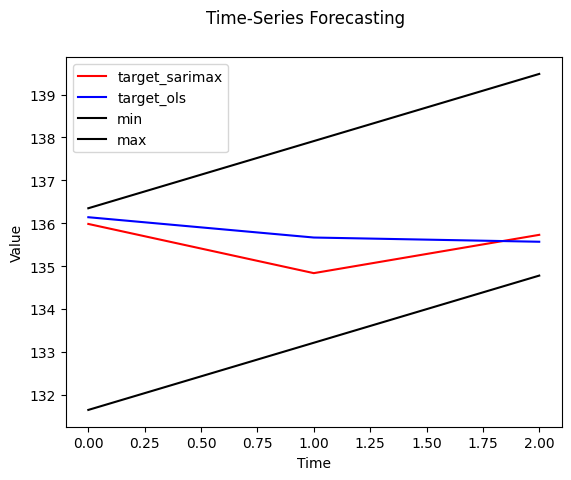

In [101]:
#PLOT
print(dataset.X_reg_target)
#print(orig_train, orig_test)
plt.figure(figsize=(12,6))
fig, ax = plt.subplots()
fig.suptitle('Time-Series Forecasting')
a=4
#plt.plot(X_test_exog_true, label='exog1')#data[look_back+1:][0]
ax.plot(orig_targets_sarimax[a], label='target_sarimax', color='r')
#ax.plot(targets_orig_gru[a], label='target_gru', color='g')
ax.plot(orig_targets_ols[a], label='target_ols', color='b')
#ax.plot(hyper[a], label='actual', color='y')
ax.plot(min_bound_true_sarimax[a], label='min', color='black')
ax.plot(max_bound_true_sarimax[a], label='max', color='black')
plt.xlabel('Time')
plt.ylabel('Value')
#ax.title('Time-Series Forecasting')
plt.legend()
plt.show()
#Y_preds_original_gru, min_bound_true, max_bound_true
fig.savefig("forecasting.png")

In [102]:
#euclidean sarimax
def euclidean_distance(arr1, arr2):
    sum_sq = np.sum(np.square(arr1 - arr2))
    return np.sqrt(sum_sq)

print(targets_sarimax)
euclidean_min_sarimax = np.empty(targets_sarimax.shape[0])
euclidean_max_sarimax = np.empty(targets_sarimax.shape[0])

for i in range(targets_sarimax.shape[0]):
    dist_min = euclidean_distance(min_bound_sarimax[i], targets_sarimax[i])
    dist_max = euclidean_distance(targets_sarimax[i], max_bound_sarimax[i])
    euclidean_min_sarimax[i] = dist_min
    euclidean_max_sarimax[i] = dist_max
print(euclidean_min_sarimax, euclidean_max_sarimax)

[[0.04803511 0.04805129 0.04802515]
 [0.28887001 0.29484999 0.28967702]
 [0.48410547 0.49343023 0.48426723]
 [0.49688476 0.4906109  0.4925696 ]
 [0.29174536 0.28826046 0.29097334]
 [0.37921894 0.37637594 0.36737365]
 [0.3888365  0.40690455 0.38786462]
 [0.47111937 0.46695161 0.46119604]
 [0.20349516 0.2038811  0.20452966]
 [0.03804984 0.03531848 0.03726485]
 [0.33410016 0.32539505 0.33084017]
 [0.93236345 0.93238455 0.93237901]
 [0.49199939 0.49539444 0.49109414]
 [0.25366864 0.25467569 0.25595367]
 [0.32961002 0.33979481 0.34045994]
 [0.2867519  0.28721434 0.28575826]
 [0.31054059 0.31351292 0.31609088]
 [0.05942887 0.05809796 0.05679686]
 [0.02337039 0.02246145 0.02158786]
 [0.05688405 0.05322884 0.04980849]
 [0.10322179 0.10310026 0.10297886]
 [0.43593714 0.4423106  0.44648808]
 [0.3213641  0.32560173 0.32702127]
 [0.12850612 0.1285608  0.12867589]
 [0.44454801 0.44751856 0.44641823]
 [0.15855896 0.15838341 0.15819342]
 [0.26378784 0.26392221 0.262054  ]
 [0.20255734 0.20218115 0.20

[0.02028397 0.0124799  0.0218178  0.01600088 0.0143599  0.02082806
 0.05331216 0.01878163 0.01391518 0.02058719 0.01266659 0.0587553
 0.01909731 0.01191581 0.01914381 0.01161779 0.01602406 0.45123177
 0.18448043 0.59817083 0.04747685 0.02641222 0.01097527 0.02014586
 0.02668011 0.01547521 0.01487934 0.01300623 0.0234077  0.0161217
 0.01394247 0.00786219 0.0343665  0.01707048 0.86023133 0.26833321
 1.16715997 0.59533703 0.02826108 0.01532851 0.02024556 0.03434584
 0.02989058 0.01330056 0.02018582 0.03809685 0.01235369 0.02005804
 0.02704346 0.01340875 0.02273976 0.03839698 0.01585684 0.0176941
 0.02364622 0.01467906 0.01282532 0.02772512 0.01384833 0.01951273
 0.02516148 0.01638782 0.0188403  0.02368737 0.02423896 0.04290555
 0.01502444 0.012746   0.02173757 0.01834505 0.01426037 0.00965081
 0.02503647 0.03758536 0.02083805 0.0125627  0.01598076 0.0171104
 0.03391163 0.01661838 0.01548361 0.01341732 0.03524628 0.01521882
 0.01984023 0.0148944  0.01730026 0.01278154 0.01953597 0.01217559

<Figure size 1200x600 with 0 Axes>

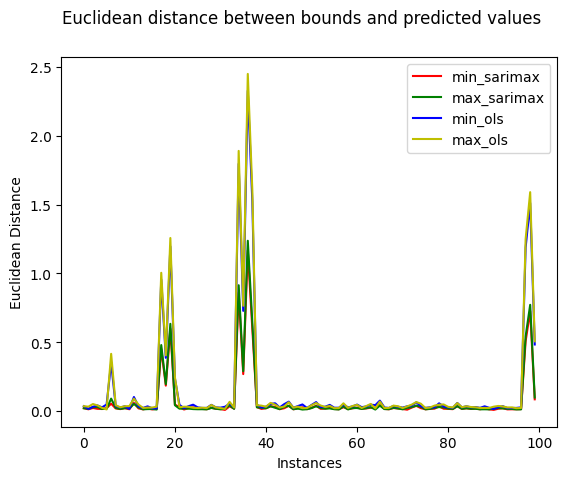

In [108]:
print(euclidean_min_sarimax, euclidean_max_sarimax, euclidean_min_ols, euclidean_max_ols)
plt.figure(figsize=(12,6))
fig, ax = plt.subplots()
fig.suptitle('Euclidean distance between bounds and predicted values')
ax.plot(euclidean_min_sarimax, label='min_sarimax', color='r')
ax.plot(euclidean_max_sarimax, label='max_sarimax', color='g')
ax.plot(euclidean_min_ols[:,0], label='min_ols', color='b')
ax.plot(euclidean_max_ols[:,0], label='max_ols', color='y')
plt.xlabel('Instances')
plt.ylabel('Euclidean Distance')
plt.legend()
plt.show()
fig.savefig("euclidean.png")

In [123]:
#RMSE sarimax 
def rmse(Y_test, Y_pred):
    return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
exogs_orig_sarimax = np.empty(len(CHANGE_COLS))   
exogs_orig = np.empty(len(CHANGE_COLS))   
rmse_sarimax = np.empty(len(CHANGE_COLS)) 
print(exogs_sarimax, pred_exog[rand_test_idx])

for i in range(exogs_sarimax.shape[0]):
    # Compute RMSE
    rmse_sarimax = (rmse(exogs_sarimax[i], pred_exog[rand_test_idx][i]))

print(rmse_sarimax)

                        




[[[0.2234152  0.22414255 0.22704691 0.22289771]
  [0.22349045 0.22023079 0.2220467  0.22022924]
  [0.22336887 0.22268419 0.22349642 0.22462295]]

 [[1.80326569 1.80380714 1.80460918 1.80333817]
  [1.77880669 1.7773248  1.7772404  1.77764893]
  [1.80586481 1.80542767 1.8062675  1.80582011]]

 [[2.85609913 2.85741472 2.85825658 2.85668397]
  [2.69963241 2.69779515 2.69747329 2.69838071]
  [2.85532689 2.85415673 2.85565114 2.85466361]]

 ...

 [[0.49622399 0.49427059 0.49682859 0.49366501]
  [0.49490559 0.49380869 0.49447387 0.49419609]
  [0.49025622 0.49152571 0.49242917 0.49446714]]

 [[0.57767344 0.57729149 0.57904565 0.57724881]
  [0.5959518  0.5960415  0.59485132 0.59483784]
  [0.60674083 0.60655469 0.60770011 0.60528904]]

 [[0.55040991 0.55122119 0.55151546 0.5498969 ]
  [0.56218064 0.56065977 0.56073219 0.56177175]
  [0.56808305 0.56753528 0.57006675 0.56970239]]] [[[0.7000096  0.70073694 0.7036413  0.6994921 ]
  [0.6914421  0.6881825  0.6899983  0.68818086]
  [0.6789474  0.678262

In [ ]:
#OLD CODE

In [ ]:
#NBEATS
import tensorflow as tf
from nbeats_keras.model import NBeatsNet

# Prepare the data
X = dataset.X_train_exog  # Shape: (num_samples, back_horizon, num_features)
y = dataset.X_train_target  # Shape: (num_samples, horizon)

# Set random seed for reproducibility
tf.random.set_seed(args.random_seed)

# Define model hyperparameters
horizon, back_horizon = args.horizon, args.back_horizon

# Create the N-BEATSx model
nbeats_model = NBeatsNet(
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    forecast_length=horizon,
    backcast_length=back_horizon,
    hidden_layer_units=256,
)

# Compile the model
nbeats_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="mae"
)

# Train the model
nbeats_model.fit(X, y, epochs=100, verbose=0)

# Make predictions
pred_nbeats = nbeats_model.predict(dataset.X_test_exog)  # Predictions on the test set
print(pred_nbeats)

mean_smape, mean_rmse = forecast_metrics(dataset, pred_nbeats)
print(
    f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)

In [ ]:
#statistical
from statsmodels.tsa.statespace.sarimax import SARIMAX

#orig_train = orig_train.dropna()
#orig_test = orig_test.dropna()
#endog = orig_train[orig_train.patient_id==544].glucose
#exog = orig_train[orig_train.patient_id==544].drop(['glucose', 'time', 'patient_id'], axis=1)
#exog_pred = orig_test[orig_test.patient_id==544].drop(['glucose', 'time', 'patient_id'], axis=1)
#endog_pred = orig_test[orig_test.patient_id==544].glucose
#print(orig_test, endog_pred)
#print(np.asarray(endog), np.asarray(exog))
print(y[0],X[0])
mod = sm.tsa.SARIMAX(endog=np.asarray(y[0]), exog=np.asarray(X[0]), order=(1,0,0))
#res = mod.fit(disp=False)
mod = mod.fit(disp=False)
start_params = mod.params
print(mod.summary())
pred = mod.forecast(horizon, start_params=start_params, exog=np.asarray(dataset.X_test_exog[0])[-horizon:])
print(pred)
max_iter = 100
it = 0
learning_rate = 0.0001
gradient=lambda v: 4 * v**3 - 10 * v - 3
exog_pred_change = np.asarray(dataset.X_test_exog[0])[-horizon:]
print("max_min", max_bound, min_bound)
while ((pred>max_bound).any() or (pred<min_bound).any()) and (it<max_iter):
    #change (X_e)
    print(it)
    diff = -learning_rate * gradient(exog_pred_change)
    exog_pred_change += diff
    it += 1
    pred = mod.forecast(horizon, start_params=start_params, exog=exog_pred_change)
    print(pred)
    
print(pred)

In [ ]:
#regression
import statsmodels.api as sm

def mean_squared_error(y_true, y_predicted):
    # Calculating the loss or cost
    cost = np.sum((y_true-y_predicted)**2) / len(y_true)
    return cost
    
orig_train = orig_train.dropna()
orig_test = orig_test.dropna()
endog = orig_train[orig_train.patient_id==591].glucose
exog = orig_train[orig_train.patient_id==591].drop(['glucose', 'time', 'patient_id'], axis=1)
exog_pred = orig_test[orig_test.patient_id==591].drop(['glucose', 'time', 'patient_id'], axis=1)
endog_pred = orig_test[orig_test.patient_id==591].glucose
print(orig_test, endog_pred)
print(np.asarray(endog), np.asarray(exog))
forest = sm.OLS(np.asarray(endog), np.asarray(exog)).fit()
pred = forest.predict(np.asarray(exog_pred))
print(pred)
max_iter = 100
it = 0
learning_rate = 0.0001
gradient=lambda v: 4 * v**3 - 10 * v - 3
exog_pred_change = np.asarray(exog_pred)
print("max_min", max_bound, min_bound)
while ((pred>max_bound).any() or (pred<min_bound).any()) and (it<max_iter):
    #change (X_e)
    print(it)
    diff = -learning_rate * gradient(exog_pred_change)
    exog_pred_change += diff
    it += 1
    pred = forest.predict(exog_pred_change)
    print(pred)
    
print(pred)